In [125]:
# imports


""""


"""

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from scipy import integrate
from astropy.coordinates import SkyCoord
import os

import astropy.units as u

import astropy.units as u
import matplotlib.pyplot as plt
from mocpy import MOC
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.coordinates import Angle


from NIRSpec import *

RA range: 53.118964157203955 to 53.20277788893667 degrees
Dec range: -27.824491111100002 to -27.750350732057203 degrees
RA of the four corners: [53.118964157203955, 53.15863281986126, 53.20277788893667, 53.1631122222]
Dec of the four corners: [-27.789317569502852, -27.750350732057203, -27.785511637071558, -27.824491111100002]


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_65498/3793244996.py:54: DeprecationWarning: This method is deprecated and has been replaced by contains_lonlat
  mask_flat = moc.contains(grid_coords.ra,grid_coords.dec)


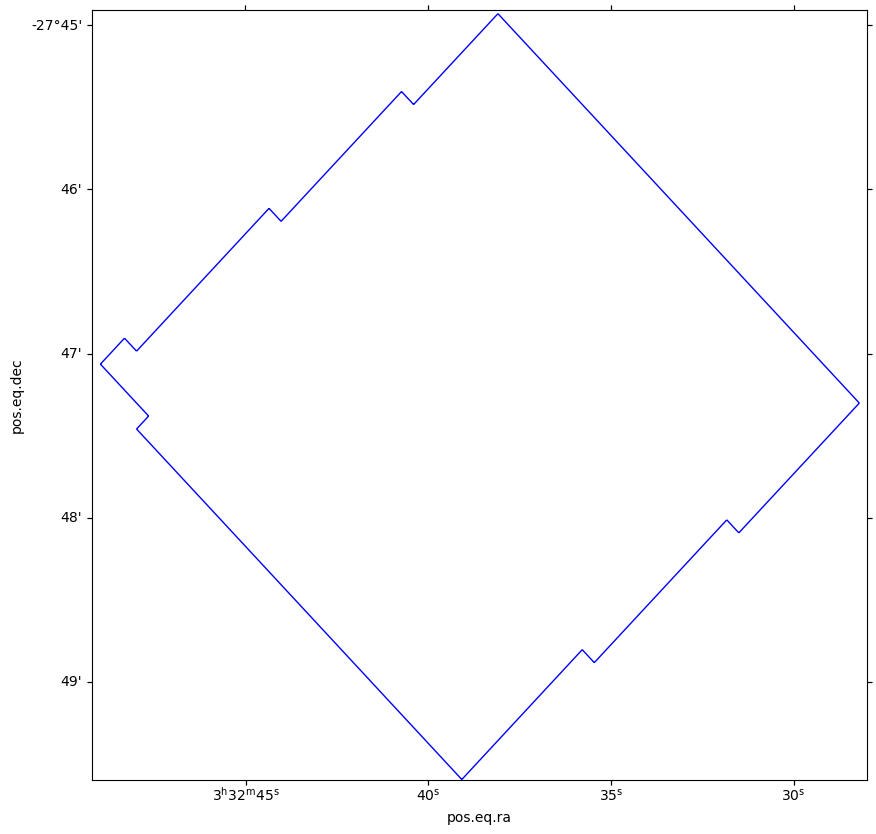

In [149]:
from mpdaf.obj import Cube
from astropy.coordinates import Angle

# Get the RA and Dec bounds of the cube and create a MOC from it

"""
I create this moc which i believe is a polygon with the vertices of the cube being vertices_ra, vertices_dec
Is this done correctly?
If it is correct, how do i create a mask of true and false from the moc?
"""


def get_cube_ra_dec_bounds(cube):
    # Get spatial dimensions
    ny, nx = cube.shape[1], cube.shape[2]  
    wcs = cube.wcs

    # Define the four corners in pixel coordinates
    corners = [(0, 0), (nx-1, 0), (0, ny-1), (nx-1, ny-1)]

    # Convert each corner to RA and Dec
    ra_dec_corners = wcs.pix2sky(corners, unit='deg')
    
    # Separate RA and Dec values
    ras = [coord[1] for coord in ra_dec_corners]
    decs = [coord[0] for coord in ra_dec_corners]
    ra_min, ra_max = min(ras), max(ras)
    dec_min, dec_max = min(decs), max(decs)

    dec1, ra1 = ra_dec_corners[2]
    dec2, ra2 = ra_dec_corners[3]
    dec3, ra3 = ra_dec_corners[1]
    dec4, ra4 = ra_dec_corners[0]

    vertices_ra = [ra1, ra2, ra3, ra4]
    vertices_dec = [dec1, dec2, dec3, dec4] 

    ##### COMPARE to below and edit to find best wayto apply the mask 
    # I have more sources in part becuse final result is crossedmatched with muse expected 


    # Create a grid of RA and Dec values
    ra_grid, dec_grid = np.meshgrid(np.linspace(ra_min, ra_max, nx),
                                    np.linspace(dec_min, dec_max, ny))

    # Flatten the grids for easier processing
    ra_flat = ra_grid.flatten()
    dec_flat = dec_grid.flatten()

    # Create SkyCoord objects for the grid
    grid_coords = SkyCoord(ra=ra_flat, dec=dec_flat, unit=u.deg)

    # Check containment within the MOC
    mask_flat = moc.contains(grid_coords.ra,grid_coords.dec)

    # Reshape the mask to match the original grid shape
    mask = mask_flat.reshape(ra_grid.shape)

    return ra_min, ra_max, dec_min, dec_max, vertices_ra, vertices_dec, mask


cube = Cube('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits')
ra_min, ra_max, dec_min, dec_max, vertices_ra, vertices_dec, mask= get_cube_ra_dec_bounds(cube)
print(f"RA range: {ra_min} to {ra_max} degrees")
print(f"Dec range: {dec_min} to {dec_max} degrees")
print(f"RA of the four corners: {vertices_ra}")
print(f"Dec of the four corners: {vertices_dec}")

# Create a SkyCoord object for the vertices
skycoord = SkyCoord(ra=vertices_ra, dec=vertices_dec, unit=u.deg)

# Create MOC from polygon
moc = MOC.from_polygon_skycoord(skycoord, max_depth=15)

#corners = [(0, 0), (nx-1, 0), (nx-1, ny-1), (0, ny-1)]
#ra_dec_corners = wcs.pixel_to_world(corners)


# 'mask' is now a 2D array of True/False



fig = plt.figure(figsize=(10, 10))
wcs = moc.wcs(fig)
ax = fig.add_subplot(projection=wcs)
moc.border(ax, wcs, color='blue')



In [150]:
# input dja csv file (bound by ra and dec limits already)
csv_file = '/Users/s2537809/Downloads/mosaic_DJA.csv'  
csv_data = Table.read(csv_file, format='csv')

def filter_sources_in_moc(csv_data, moc, z_min=4.0, z_max=6.6):
    """
    Filters sources based on their location inside the MOC and redshift range.

    Parameters:
        csv_data (Table): Input CSV data with RA, Dec, and z columns.
        moc (MOC): MOC object for spatial filtering.
        z_min (float): Minimum redshift for sources (default: 4.0).
        z_max (float): Maximum redshift for sources (default: 6.6).

    Returns:
        Table: Filtered sources satisfying all criteria.
    """
    # Extract RA, Dec, and redshift from the input data
    ra_sources = csv_data['ra'] * u.deg
    dec_sources = csv_data['dec'] * u.deg
    redshift = csv_data['z']

    # Check which sources are inside the MOC
    inside_moc_mask = moc.contains_lonlat(lon=ra_sources, lat=dec_sources)

    # Filter sources inside the MOC
    sources_inside_moc = csv_data[inside_moc_mask]

    # Apply redshift range filtering
    filtered_sources = sources_inside_moc
    #redshift_mask = (sources_inside_moc['z'] > z_min) & (sources_inside_moc['z'] < z_max)
    #filtered_sources = sources_inside_moc[redshift_mask]

    print (f"Number of sources in CSV: {len(csv_data)}")    
    print(f"Number of sources inside MOC: {inside_moc_mask.sum()}")
    print(f"Filtered sources RA: {filtered_sources['ra']}")
    print(f"Filtered sources Dec: {filtered_sources['dec']}")

   
    return filtered_sources

filtered_sources = filter_sources_in_moc(csv_data, moc, z_min=5.8, z_max=6.6)
print(f"Number of filtered sources: {len(filtered_sources)}")



Number of sources in CSV: 2565
Number of sources inside MOC: 1638
Filtered sources RA:     ra   
---------
53.134923
53.167464
53.156837
53.173514
53.162878
53.155853
53.153565
53.169953
 53.15446
53.156073
      ...
53.159527
53.162866
53.164959
53.165564
53.167185
 53.15813
53.172572
53.157285
53.161719
53.172098
53.164292
Length = 1638 rows
Filtered sources Dec:    dec    
----------
-27.772706
-27.772006
-27.767155
-27.771867
-27.769284
-27.807699
-27.766503
-27.768402
-27.771433
-27.767654
       ...
-27.771524
-27.771698
-27.773753
-27.772662
-27.774606
-27.786435
-27.813778
-27.796569
 -27.78539
-27.772244
 -27.77417
Length = 1638 rows
Number of filtered sources: 1638


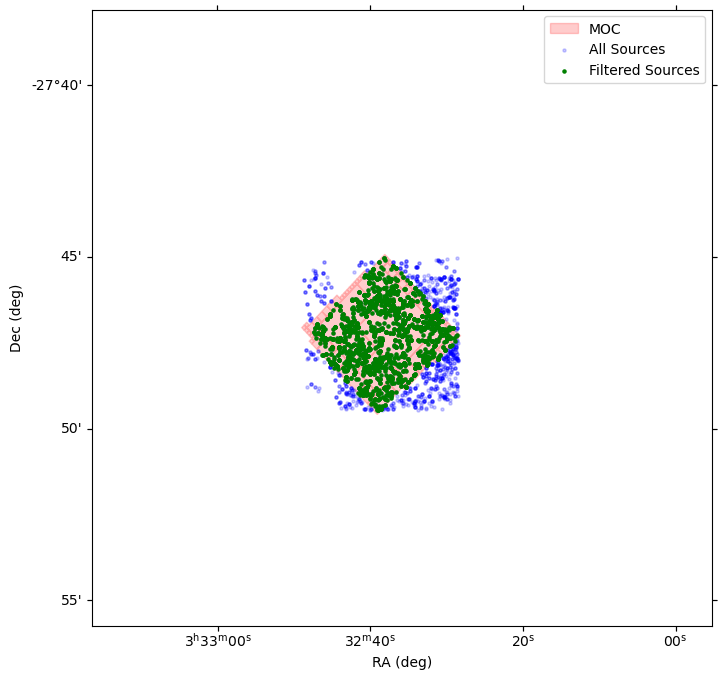

In [151]:
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
import matplotlib.pyplot as plt

def visualize_moc_and_sources(moc, csv_data, filtered_sources):
    """
    Visualizes the MOC and the sources.

    Parameters:
        moc (MOC): MOC object representing the coverage area.
        csv_data (Table): Original source data with RA and Dec columns.
        filtered_sources (Table): Sources filtered by the MOC.
    """
    # Define WCS for the plot
    wcs = WCS(naxis=2)
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    wcs.wcs.crval = [53.15, -27.78]  # Central RA, Dec values of the region
    wcs.wcs.crpix = [150, 150]  # Reference pixel
    wcs.wcs.cdelt = [-0.001, 0.001]  # Pixel scale in degrees

    # Create the plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection=wcs)

    # Plot the MOC
    moc.fill(ax=ax, wcs=wcs, alpha=0.2, label="MOC", color="red")

    # Plot all sources
    ax.scatter(
        csv_data["ra"], csv_data["dec"],
        s=5, alpha=0.2, color="blue", transform=ax.get_transform("world"), label="All Sources"
    )

    # Plot filtered sources
    ax.scatter(
        filtered_sources["ra"], filtered_sources["dec"],
        s=5, color="green", transform=ax.get_transform("world"), label="Filtered Sources"
    )

    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")
    ax.legend()
    plt.show()

visualize_moc_and_sources(moc, csv_data, filtered_sources)




Text(0, 0.5, 'Dec (deg)')

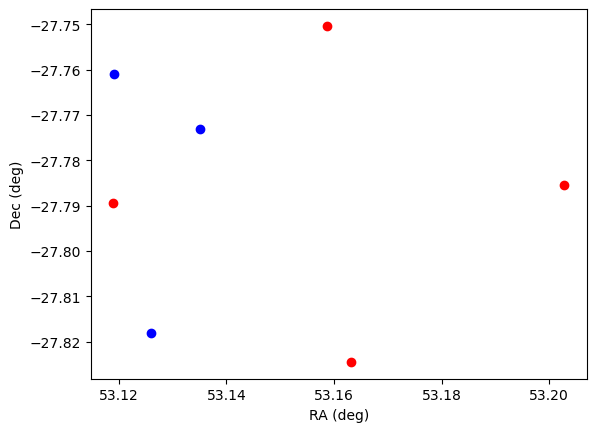

In [127]:
ra_ob = [53.126, 53.135, 53.119]
dec_ob = [-27.818, -27.773, -27.761]
# plot the four corners
fig = plt.figure()

plt.plot(vertices_ra, vertices_dec, 'ro')
plt.plot(ra_ob, dec_ob, 'bo')

plt.xlabel('RA (deg)')
plt.plot
plt.xlabel('RA (deg)')  
plt.ylabel('Dec (deg)')






In [98]:
# This demonstartes the need for the redshift ranges applied below

nirspec = [0.6, 5.3]*u.micron
nirspeca = nirspec.to(u.AA, equivalencies=u.spectral())
print(nirspeca)


Lya = 1215.67*u.AA

z = nirspeca/Lya - 1
print(z)

muse = [4750.0, 9350.0]*u.AA

z_muse = muse/Lya - 1

print(z_muse)


lya1 = 1215.67*u.AA*(1 + 5.8)

print (lya1.to(u.micron))

[ 6000. 53000.] Angstrom
[ 3.93554994 42.59735784]
[2.90731037 6.691232  ]
0.8266556000000002 micron


Number of sources in the input CSV file: 2565
Converted RA and Dec to degrees with units: deg, deg
Polygon vertices (RA): [53.118964157203955, 53.15863281986126, 53.20277788893667, 53.1631122222, 53.118964157203955]
Polygon vertices (Dec): [-27.789317569502852, -27.750350732057203, -27.785511637071558, -27.824491111100002, -27.789317569502852]
Number of sources inside the MOC: 2562
Number of sources with 5.8 < z < 6.6: 187


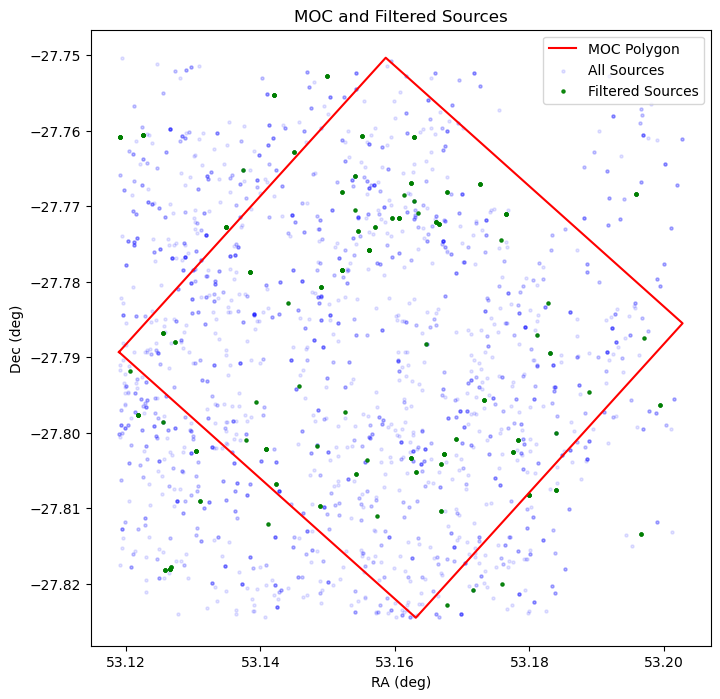

       jname         ndup  uid      ra    ... slit        FITS       Fnu Flam
-------------------- ---- ----- --------- ... ---- ----------------- --- ----
j033229.22m274751.48    5  7301 53.121759 ...   -- FITS   zfit   spl  --   --
j033232.38m274621.74    5  7302 53.134923 ...   -- FITS   zfit   spl  --   --
j033230.37m274905.13    5  7316 53.126535 ...   -- FITS   zfit   spl  --   --
j033239.09m274609.42    5  7367 53.162878 ...   -- FITS   zfit   spl  --   --
j033238.55m274617.77    5  7634 53.160634 ...   -- FITS   zfit   spl  --   --
j033229.22m274751.48    5  7301 53.121759 ...   -- FITS   zfit   spl  --   --
j033232.38m274621.74    5  7302 53.134923 ...   -- FITS   zfit   spl  --   --
j033228.59m274538.89    9  7313 53.119112 ...   -- FITS   zfit   spl  --   --
j033230.37m274905.13    5  7316 53.126535 ...   -- FITS   zfit   spl  --   --
j033240.15m274810.33    5  7362 53.167303 ...   -- FITS   zfit   spl  --   --
                 ...  ...   ...       ... ...  ...              

In [99]:

# input dja csv file (bound by ra and dec limits already)
csv_file = '/Users/s2537809/Downloads/mosaic_DJA.csv'  
csv_data = Table.read(csv_file, format='csv')

def filter_sources(csv_data, vertices_ra, vertices_dec, moc, z_min=4.0, z_max=6.6):
    """
    Filters sources based on their location inside the MOC, 
    redshift range (z_min to z_max), and spatial extent.

    Parameters:
        csv_data (Table): Input CSV data with RA, Dec, and z columns.
        vertices_ra (list): RA values of the polygon vertices.
        vertices_dec (list): Dec values of the polygon vertices.
        moc (MOC): MOC object for spatial filtering.
        z_min (float): Minimum redshift for sources (default: 4.0 for NIRSpec).
        z_max (float): Maximum redshift for sources (default: 6.6 for MUSE cube).

    Returns:
        Table: Filtered sources satisfying all criteria.
    """
    # Extract RA and Dec of sources from CSV
    ra_sources = csv_data['ra']
    dec_sources = csv_data['dec']

    # Debug: Print number of sources in the CSV file
    print(f"Number of sources in the input CSV file: {len(csv_data)}")

    # Create a SkyCoord object for the sources
    sky_coords = SkyCoord(ra=ra_sources, dec=dec_sources, unit=u.deg)

    # Convert RA and Dec to degree units with explicit angular units
    lon = sky_coords.ra.to(u.deg)
    lat = sky_coords.dec.to(u.deg)

    # Debug: Ensure RA and Dec units are in degrees
    print(f"Converted RA and Dec to degrees with units: {lon.unit}, {lat.unit}")

    # Ensure polygon vertices are closed
    vertices_ra.append(vertices_ra[0])
    vertices_dec.append(vertices_dec[0])
    print(f"Polygon vertices (RA): {vertices_ra}")
    print(f"Polygon vertices (Dec): {vertices_dec}")

    # Check which sources are inside the MOC
    inside_moc_mask = moc.contains_lonlat(lon=lon, lat=lat)

    # Debug: Validate the MOC filtering
    print(f"Number of sources inside the MOC: {inside_moc_mask.sum()}")

    # Apply the MOC spatial filter
    filtered_sources = csv_data[inside_moc_mask]

    # Apply the redshift range filter (z_min < z < z_max)
    redshift_mask = (filtered_sources['z'] > z_min) & (filtered_sources['z'] < z_max)
    filtered_sources = filtered_sources[redshift_mask]

    # Debug: Print the number of sources after the redshift filter
    print(f"Number of sources with {z_min} < z < {z_max}: {len(filtered_sources)}")

    # Plot the sources and polygon
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("MOC and Filtered Sources")
    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")

    # Plot the polygon
    ax.plot(vertices_ra, vertices_dec, 'r-', label="MOC Polygon")

    # Plot all sources
    ax.scatter(ra_sources, dec_sources, color='blue', s=5, label="All Sources", alpha=0.1)

    # Plot filtered sources
    ax.scatter(filtered_sources['ra'], filtered_sources['dec'], color='green', s=5, label="Filtered Sources", alpha=0.9)

    plt.legend()
    plt.show()

    # Debug: Ensure all filtered sources are inside the MOC
    assert all(
        moc.contains_lonlat(lon=filtered_sources['ra'] * u.deg, lat=filtered_sources['dec'] * u.deg)
    ), "Some filtered sources are outside the MOC!"

    return filtered_sources

filtered_sources = filter_sources(csv_data, vertices_ra, vertices_dec, moc, z_min=5.8)
print(filtered_sources)


Number of sources in the input CSV file: 2565
Number of sources in the MOC: 2195
Number of sources in the MOC with 5.8 < z < 6.6: 161
       jname         ndup  uid      ra    ... slit        FITS       Fnu Flam
-------------------- ---- ----- --------- ... ---- ----------------- --- ----
j033229.22m274751.48    5  7301 53.121759 ...   -- FITS   zfit   spl  --   --
j033232.38m274621.74    5  7302 53.134923 ...   -- FITS   zfit   spl  --   --
j033239.09m274609.42    5  7367 53.162878 ...   -- FITS   zfit   spl  --   --
j033238.55m274617.77    5  7634 53.160634 ...   -- FITS   zfit   spl  --   --
j033229.22m274751.48    5  7301 53.121759 ...   -- FITS   zfit   spl  --   --
j033232.38m274621.74    5  7302 53.134923 ...   -- FITS   zfit   spl  --   --
j033240.15m274810.33    5  7362 53.167303 ...   -- FITS   zfit   spl  --   --
j033242.37m274615.98    5  7617  53.17655 ...   -- FITS   zfit   spl  --   --
j033236.98m274557.82    9  7629 53.154087 ...   -- FITS   zfit   spl  --   --
j033237.

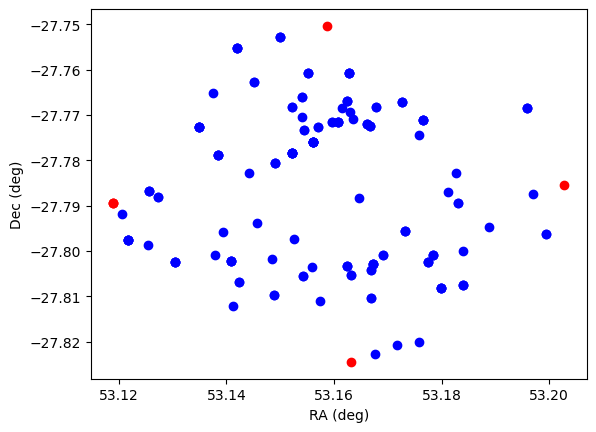

In [121]:
def filter_sources_debug(csv_data, vertices_ra, vertices_dec, moc, z_min=4.0, z_max=6.6):
    ra_sources = csv_data['ra']
    dec_sources = csv_data['dec']

    print(f"Number of sources in the input CSV file: {len(csv_data)}")

    sky_coords = SkyCoord(ra=ra_sources, dec=dec_sources, unit=u.deg)
    lon = sky_coords.ra.to(u.deg)
    lat = sky_coords.dec.to(u.deg)

    # Debug: Check RA/Dec ranges
    print(f"RA range: {lon.min()} to {lon.max()}")
    print(f"Dec range: {lat.min()} to {lat.max()}")

    # Check MOC boundaries
    print(f"MOC bounds: {moc.min_lon}, {moc.max_lon}, {moc.min_lat}, {moc.max_lat}")

    # Ensure polygon vertices are closed
    polygon_ra = vertices_ra + [vertices_ra[0]]
    polygon_dec = vertices_dec + [vertices_dec[0]]

    inside_moc_mask = moc.contains_lonlat(lon=lon, lat=lat)
    print(f"Number of sources inside MOC: {inside_moc_mask.sum()}")

    # Debug specific cases
    for i, (ra, dec, inside) in enumerate(zip(lon, lat, inside_moc_mask)):
        if not inside and vertices_ra[0] < ra < vertices_ra[2] and vertices_dec[0] < dec < vertices_dec[2]:
            print(f"Potential misclassified source at index {i}: RA={ra}, Dec={dec}")

    filtered_sources = csv_data[inside_moc_mask]

    redshift_mask = (filtered_sources['z'] > z_min) & (filtered_sources['z'] < z_max)
    filtered_sources = filtered_sources[redshift_mask]

    print(f"Number of sources with {z_min} < z < {z_max}: {len(filtered_sources)}")

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("MOC and Filtered Sources")
    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")

    ax.plot(polygon_ra, polygon_dec, 'r-', label="MOC Polygon")
    ax.scatter(ra_sources, dec_sources, color='blue', s=5, label="All Sources", alpha=0.1)
    ax.scatter(filtered_sources['ra'], filtered_sources['dec'], color='green', s=5, label="Filtered Sources", alpha=0.9)

    plt.legend()
    plt.show()



    return filtered_sources

filtered_sources = filter_sources(csv_data, vertices_ra, vertices_dec, moc, z_min=5.8)
print(filtered_sources)



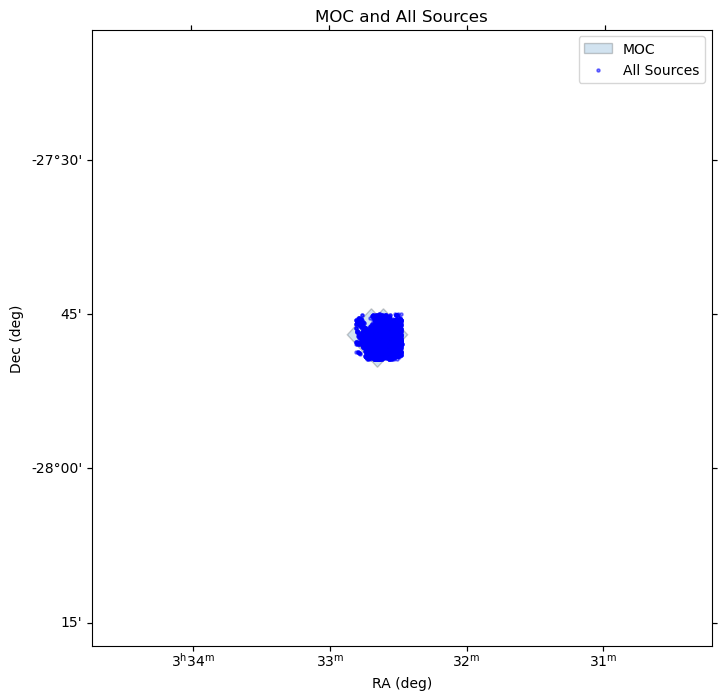

In [109]:
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs import WCS
import matplotlib.pyplot as plt

# Create a basic WCS object for plotting in RA/Dec
wcs = WCS(naxis=2)
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs.wcs.crval = [vertices_ra[0], vertices_dec[0]]  # Reference point in the center of the MOC
wcs.wcs.cdelt = [-0.001, 0.001]  # Pixel size
wcs.wcs.crpix = [500, 500]  # Arbitrary center pixel

# Plot the MOC and sources
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=wcs)

# Plot the MOC (in red)
moc.fill(ax=ax, wcs=wcs, alpha=0.2, label="MOC")

# Overlay sources
ax.scatter(csv_data['ra'], csv_data['dec'], transform=ax.get_transform("world"),
           s=5, alpha=0.5, color="blue", label="All Sources")

ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.set_title("MOC and All Sources")
ax.legend()
plt.show()




In [118]:
def filter_sources_in_moc(csv_data, moc, z_min=4.0, z_max=6.6):
    """
    Filters sources based on their location inside the MOC and redshift range.

    Parameters:
        csv_data (Table): Input CSV data with RA, Dec, and z columns.
        moc (MOC): MOC object for spatial filtering.
        z_min (float): Minimum redshift for sources (default: 4.0).
        z_max (float): Maximum redshift for sources (default: 6.6).

    Returns:
        Table: Filtered sources satisfying all criteria.
    """
    # Extract RA, Dec, and redshift from the input data
    ra_sources = csv_data['ra'] * u.deg
    dec_sources = csv_data['dec'] * u.deg
    redshift = csv_data['z']

    # Check which sources are inside the MOC
    inside_moc_mask = moc.contains_lonlat(lon=ra_sources, lat=dec_sources)

    # Filter sources inside the MOC
    sources_inside_moc = csv_data[inside_moc_mask]

    # Apply redshift range filtering
    redshift_mask = (sources_inside_moc['z'] > z_min) & (sources_inside_moc['z'] < z_max)
    filtered_sources = sources_inside_moc[redshift_mask]

    print(f"Number of sources inside MOC: {inside_moc_mask.sum()}")
    print(f"Filtered sources RA: {filtered_sources['ra']}")
    print(f"Filtered sources Dec: {filtered_sources['dec']}")

   
    return filtered_sources

filtered_sources = filter_sources_in_moc(csv_data, moc, z_min=5.8, z_max=6.6)
print(f"Number of filtered sources: {len(filtered_sources)}")



Number of sources inside MOC: 2195
Filtered sources RA:     ra   
---------
53.121759
53.134923
53.162878
53.160634
53.121759
53.134923
53.167303
 53.17655
53.154087
53.156129
      ...
53.162801
 53.17324
53.166129
53.163067
 53.17752
53.130437
53.152613
 53.19938
53.167726
53.156129
53.159527
Length = 161 rows
Filtered sources Dec:    dec    
----------
-27.797633
-27.772706
-27.769284
-27.771604
-27.797633
-27.772706
 -27.80287
-27.771106
-27.766062
-27.775854
       ...
-27.760838
-27.795674
-27.772036
-27.805201
 -27.80252
-27.802361
 -27.79731
-27.796274
-27.768162
-27.775854
-27.771524
Length = 161 rows
Number of filtered sources: 161


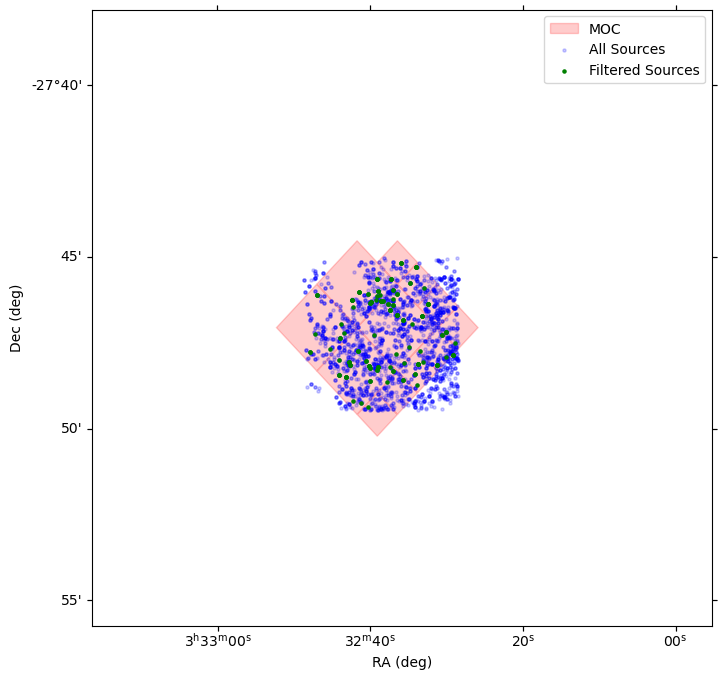

In [120]:
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
import matplotlib.pyplot as plt

def visualize_moc_and_sources(moc, csv_data, filtered_sources):
    """
    Visualizes the MOC and the sources.

    Parameters:
        moc (MOC): MOC object representing the coverage area.
        csv_data (Table): Original source data with RA and Dec columns.
        filtered_sources (Table): Sources filtered by the MOC.
    """
    # Define WCS for the plot
    wcs = WCS(naxis=2)
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    wcs.wcs.crval = [53.15, -27.78]  # Central RA, Dec values of the region
    wcs.wcs.crpix = [150, 150]  # Reference pixel
    wcs.wcs.cdelt = [-0.001, 0.001]  # Pixel scale in degrees

    # Create the plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection=wcs)

    # Plot the MOC
    moc.fill(ax=ax, wcs=wcs, alpha=0.2, label="MOC", color="red")

    # Plot all sources
    ax.scatter(
        csv_data["ra"], csv_data["dec"],
        s=5, alpha=0.2, color="blue", transform=ax.get_transform("world"), label="All Sources"
    )

    # Plot filtered sources
    ax.scatter(
        filtered_sources["ra"], filtered_sources["dec"],
        s=5, color="green", transform=ax.get_transform("world"), label="Filtered Sources"
    )

    ax.set_xlabel("RA (deg)")
    ax.set_ylabel("Dec (deg)")
    ax.legend()
    plt.show()

visualize_moc_and_sources(moc, csv_data, filtered_sources)




Number of sources in the input CSV file: 2565
Number of sources in the MOC: 2195
Number of sources in the MOC with 5.8 < z < 6.6: 161


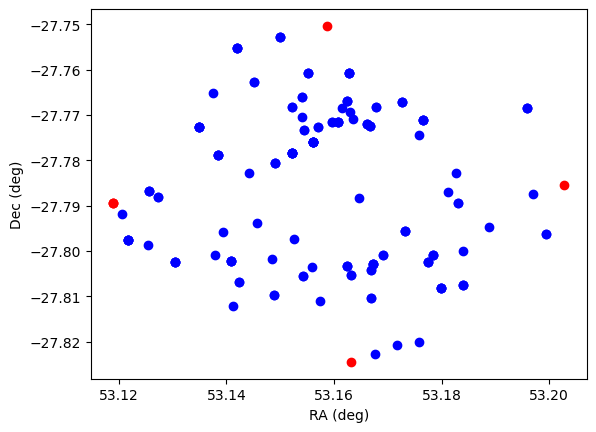

In [116]:
# the porblem i the moc is not working properly
### this needs to be moved tp python script 

# input dja csv file (bound by ra and dec limits already)
csv_file = '/Users/s2537809/Downloads/mosaic_DJA.csv'  
csv_data = Table.read(csv_file, format='csv')

def filter_sources(csv_data,vertices_ra,vertices_dec ,moc, z_min=4.0, z_max=6.6):
    """
    Filters sources based on their location inside the MOC, 
    redshift range (z_min to z_max), and spatial extent.
    
    Parameters:
        csv_data (Table): Input CSV data with RA, Dec, and z columns.
        moc (MOC): MOC object for spatial filtering.
        z_min (float): Minimum redshift for sources (default: 4.0 for NIRSpec).
        z_max (float): Maximum redshift for sources (default: 6.6 for MUSE cube).
    
    Returns:
        Table: Filtered sources satisfying all criteria.
    """
    # Extract RA and Dec of sources from CSV
    ra_sources = csv_data['ra']
    dec_sources = csv_data['dec']

    # print the number of sources in the csv file
    print(f"Number of sources in the input CSV file: {len(csv_data)}")

    # Create a SkyCoord object for the sources
    sky_coords = SkyCoord(ra=ra_sources, dec=dec_sources, unit=u.deg)

    # Check which sources are inside the MOC - problemmmm
    inside_moc_mask = moc.contains_lonlat(sky_coords.ra, sky_coords.dec)

    # Apply the MOC spatial filter
    filtered_sources = csv_data[inside_moc_mask]
    print(f"Number of sources in the MOC: {len(filtered_sources)}")

    # Apply the redshift range filter (z_min < z < z_max)
    redshift_mask = (filtered_sources['z'] > z_min) & (filtered_sources['z'] < z_max)
    filtered_sources = filtered_sources[redshift_mask]
    print(f"Number of sources in the MOC with {z_min} < z < {z_max}: {len(filtered_sources)}")


    
    # plot the four corners
    fig = plt.figure()

    plt.plot(vertices_ra,vertices_dec, 'ro')
    plt.plot(filtered_sources['ra'], filtered_sources['dec'], 'bo')
    plt.plot
    plt.xlabel('RA (deg)')  
    plt.ylabel('Dec (deg)')


    return filtered_sources


filtered_sources = filter_sources(csv_data, vertices_ra,vertices_dec,moc, z_min =5.8) # Increase zmin so lya is not in noisy region

filtered_sources

# write the filtered sources to a new csv file
filtered_sources.write('/Users/s2537809/Downloads/mosaic_DJA_filtered.csv', format='csv', overwrite=True)

In [53]:
set = 'DJA_filtered_58_66'

download_fits_from_DJA('/Users/s2537809/Downloads/mosaic_DJA_filtered.csv', folder_name=set) 

filtered_table = filter_incomplete_spectra(filtered_sources, folder_name=set, min_wavelength=1.0, max_wavelength=4.0,target_wavelength= 1450, SNR_threshold=5.0)
filtered_table.write(f'/Users/s2537809/Downloads/{set}_table.csv', format='csv', overwrite=True)

Processing file 1/187: gds-deep-v3_g140m-f070lp_1210_13176.spec.fits
gds-deep-v3_g140m-f070lp_1210_13176.spec.fits already exists in DJA_filtered_58_66. No need to download.
Processing file 2/187: gds-deep-v3_g140m-f070lp_1210_13197.spec.fits
gds-deep-v3_g140m-f070lp_1210_13197.spec.fits already exists in DJA_filtered_58_66. No need to download.
Processing file 3/187: gds-deep-v3_g140m-f070lp_1210_13704.spec.fits
gds-deep-v3_g140m-f070lp_1210_13704.spec.fits already exists in DJA_filtered_58_66. No need to download.
Processing file 4/187: gds-deep-v3_g140m-f070lp_1210_5447.spec.fits
gds-deep-v3_g140m-f070lp_1210_5447.spec.fits already exists in DJA_filtered_58_66. No need to download.
Processing file 5/187: gds-deep-v3_g140m-f070lp_1210_9880.spec.fits
gds-deep-v3_g140m-f070lp_1210_9880.spec.fits already exists in DJA_filtered_58_66. No need to download.
Processing file 6/187: gds-deep-v3_g235m-f170lp_1210_13176.spec.fits
gds-deep-v3_g235m-f170lp_1210_13176.spec.fits already exists in D

In [49]:
filtered_table

jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam
str20,int64,int64,float64,float64,str53,str18,int64,int64,str29,int64,float64,float64,str138,str64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64
j033229.22m274751.48,5,7301,53.121759,-27.797633,gds-deep-v3_prism-clear_1210_13176.spec.fits,gds-deep-v3,13176,4,G140M G235M G395H G395M,3,5.9407,5.9407,Redshifts match v2 grade=3,JWi23 z=5.937 ; ABu23 z=5.936 ; CSi23 z=N/A,3,9.48,0.6,5.29,23.3,66.1,--,42.28,42.83,--,--,--,FITS zfit spl,--,--
j033232.38m274621.74,5,7302,53.134923,-27.772706,gds-deep-v3_prism-clear_1210_13197.spec.fits,gds-deep-v3,13197,4,G140M G235M G395H G395M,3,6.342,6.342,Redshifts match v2 grade=3,CSi23 z=N/A ; JWi23 z=6.336 ; ABu23 z=6.335,3,11.37,0.6,5.29,12.8,36.3,--,42.29,42.65,--,--,--,FITS zfit spl,--,--
j033228.59m274538.89,9,7313,53.119112,-27.760802,gds-deep-v3_prism-clear_1210_13618.spec.fits,gds-deep-v3,13618,4,G140M G235M G395H G395M,3,5.9484,5.9484,Redshifts match v2 grade=3,ABu23 z=5.944,1,16.79,0.6,5.29,-8.3,31.8,--,41.71,42.01,--,--,--,FITS zfit spl,--,--
j033229.42m274538.05,9,7314,53.12259,-27.760569,gds-deep-v3_prism-clear_1210_13620.spec.fits,gds-deep-v3,13620,4,G140M G235M G395H G395M,3,5.9199,5.9199,Redshifts match v2 grade=3,ABu23 z=5.918,1,6.55,0.6,5.29,-8.5,33.7,--,41.73,42.08,--,--,--,FITS zfit spl,--,--
j033230.37m274905.13,5,7316,53.126535,-27.818092,gds-deep-v3_prism-clear_1210_13704.spec.fits,gds-deep-v3,13704,4,G140M G235M G395H G395M,3,5.9296,5.9296,Redshifts match v2 grade=3,DKo24 z=5.920 ; CSi23 z=N/A ; ABu23 z=5.920,3,9.56,0.6,5.29,-3.3,67.2,--,42.31,42.37,--,--,--,FITS zfit spl,--,--
j033240.15m274810.33,5,7362,53.167303,-27.80287,gds-deep-v3_prism-clear_1210_5113.spec.fits,gds-deep-v3,5113,4,G140M G235M G395H G395M,3,5.8183,5.8183,Redshifts match v2 grade=3,ABu23 z=5.821,1,2.0,0.6,5.29,0.2,32.2,--,41.6,41.82,--,--,--,FITS zfit spl,--,--
j033239.99m274620.62,5,7607,53.166615,-27.772395,gds-deep-v3_prism-clear_1210_8253.spec.fits,gds-deep-v3,8253,4,G140M G235M G395H G395M,3,6.3295,6.3295,Redshifts match v2 grade=3,ABu23 z=6.327,1,3.42,0.6,5.29,-3.6,29.4,--,41.77,42.0,--,--,--,FITS zfit spl,--,--
j033242.37m274615.98,5,7617,53.17655,-27.771106,gds-deep-v3_prism-clear_1210_9414.spec.fits,gds-deep-v3,9414,4,G140M G235M G395H G395M,3,5.8916,5.8916,Redshifts match v2 grade=3,ABu23 z=5.889 ; CSi23 z=N/A ; CSi23 z=N/A ; JWi23 z=5.889,4,2.14,0.6,5.29,11.7,28.2,--,41.83,42.15,--,--,--,FITS zfit spl,--,--
j033242.20m274628.08,1,7939,53.17583,-27.774468,gds-deep-v3_prism-clear_1210_9423.spec.fits,gds-deep-v3,9423,0,--,3,6.3346,6.3346,Redshifts match v2 grade=3,ABu23 z=6.335 ; CSi23 z=N/A,2,4.19,0.6,5.29,-4.1,19.8,--,41.69,41.96,--,--,--,FITS zfit spl,--,--


Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13176.spec.fits with redshift z = 5.9407
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.01979798
    reduced chi-square = 0.00152292
    Akaike info crit   = -95.4533832
    Bayesian info crit = -94.0372828
    R-squared          = 0.96337829
[[Variables]]
    beta:         -2.46242201 +/- 0.13315629 (5.41%) (init = -1.5)
    log_FUV_1550: -19.7642691 +/- 0.01840375 (0.09%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8368


100%|██████████| 5000/5000 [00:02<00:00, 2037.96it/s]


β_UV: -2.38 with 16-84 percentile range: [-2.38, -2.38]
log_FUV_1550: -1.98e+01 with 16-84 percentile range: [-1.98e+01, -1.98e+01]


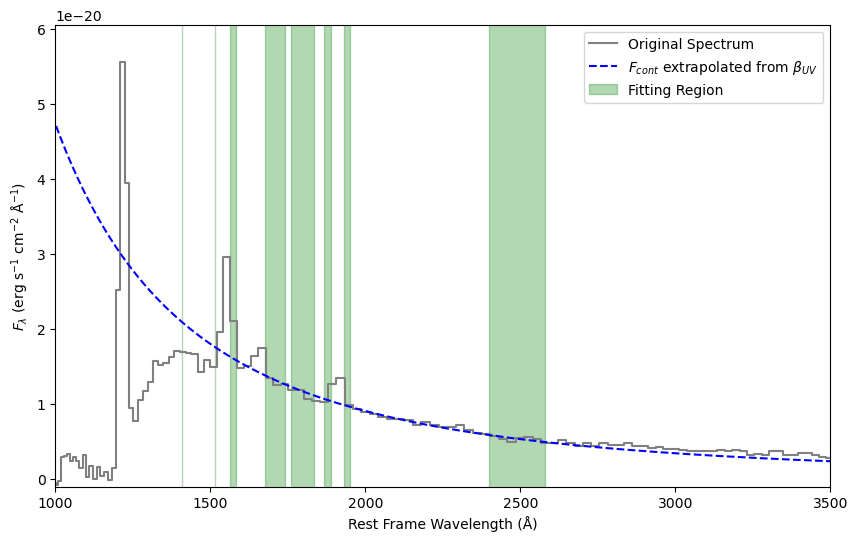

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13176.spec.fits | LyA Damping Parameter (D_LyA): 45.913
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13197.spec.fits with redshift z = 6.342
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.00661294
    reduced chi-square = 5.5108e-04
    Akaike info crit   = -103.208975
    Bayesian info crit = -101.930860
    R-squared          = 0.98624699
[[Variables]]
    beta:         -2.33884109 +/- 0.07972898 (3.41%) (init = -1.5)
    log_FUV_1550: -19.6092179 +/- 0.01209748 (0.06%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8550


100%|██████████| 5000/5000 [00:02<00:00, 2019.48it/s]


β_UV: -2.34 with 16-84 percentile range: [-2.34, -2.34]
log_FUV_1550: -1.96e+01 with 16-84 percentile range: [-1.96e+01, -1.96e+01]


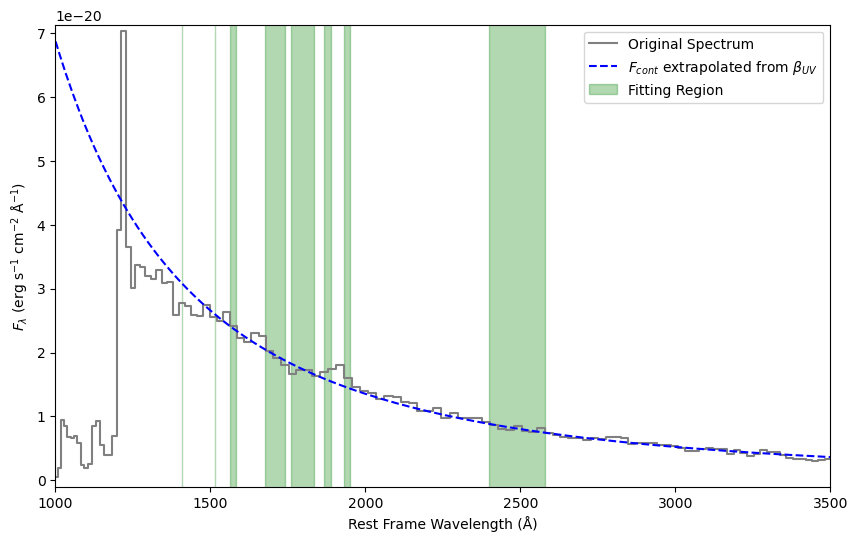

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13197.spec.fits | LyA Damping Parameter (D_LyA): 15.672
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13618.spec.fits with redshift z = 5.9484
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.00509392
    reduced chi-square = 3.9184e-04
    Akaike info crit   = -115.816379
    Bayesian info crit = -114.400278
    R-squared          = 0.98435009
[[Variables]]
    beta:         -1.84073916 +/- 0.06437270 (3.50%) (init = -1.5)
    log_FUV_1550: -19.8430909 +/- 0.00950839 (0.05%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8432


100%|██████████| 5000/5000 [00:02<00:00, 1976.87it/s]


β_UV: -1.86 with 16-84 percentile range: [-1.86, -1.86]
log_FUV_1550: -1.98e+01 with 16-84 percentile range: [-1.98e+01, -1.98e+01]


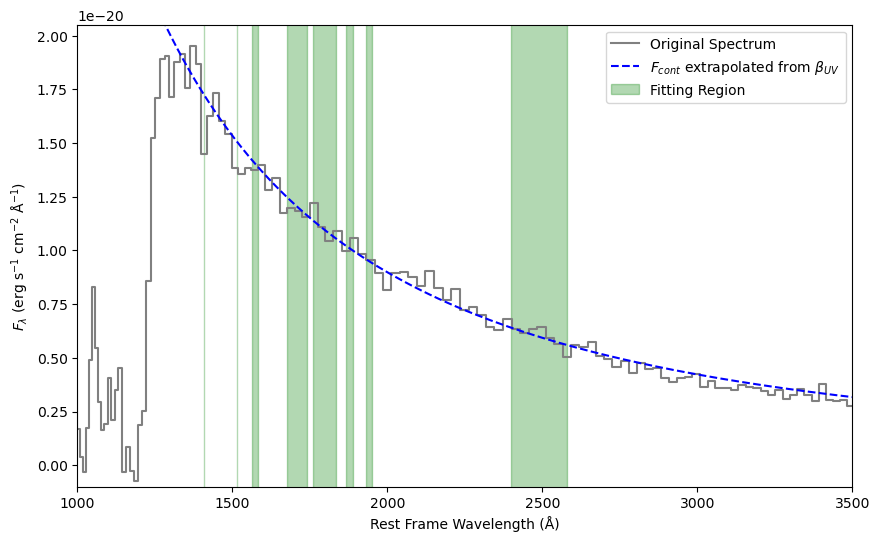

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13618.spec.fits | LyA Damping Parameter (D_LyA): 52.284
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13620.spec.fits with redshift z = 5.9199
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00637991
    reduced chi-square = 5.7999e-04
    Akaike info crit   = -95.0541586
    Bayesian info crit = -93.9242599
    R-squared          = 0.98970428
[[Variables]]
    beta:         -2.75546070 +/- 0.08473709 (3.08%) (init = -1.5)
    log_FUV_1550: -19.7999264 +/- 0.01240040 (0.06%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8425


100%|██████████| 5000/5000 [00:02<00:00, 2046.24it/s]


β_UV: -2.76 with 16-84 percentile range: [-2.76, -2.76]
log_FUV_1550: -1.98e+01 with 16-84 percentile range: [-1.98e+01, -1.98e+01]


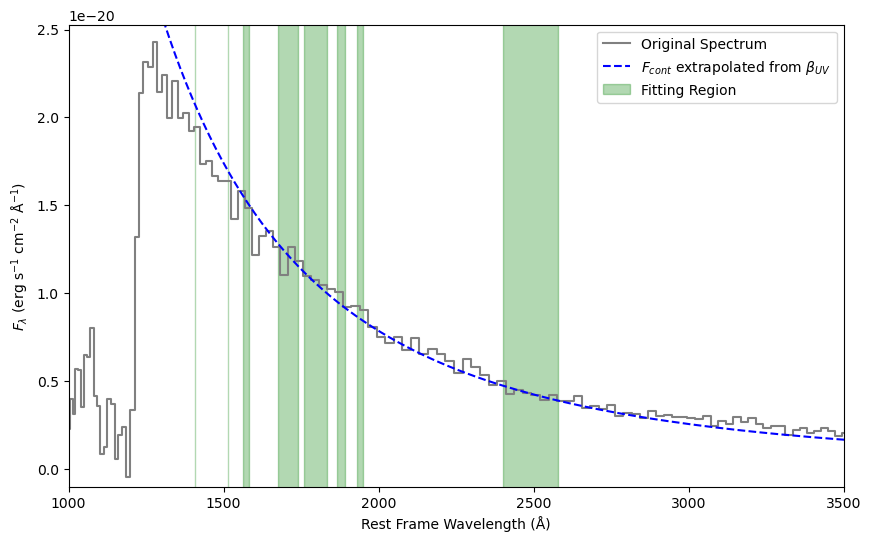

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13620.spec.fits | LyA Damping Parameter (D_LyA): 47.510
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13704.spec.fits with redshift z = 5.9296
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.02535108
    reduced chi-square = 0.00211259
    Akaike info crit   = -84.3958803
    Bayesian info crit = -83.1177657
    R-squared          = 0.93023414
[[Variables]]
    beta:         -2.03947843 +/- 0.16123296 (7.91%) (init = -1.5)
    log_FUV_1550: -20.1937623 +/- 0.02306057 (0.11%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8463


100%|██████████| 5000/5000 [00:02<00:00, 1989.00it/s]


β_UV: -2.07 with 16-84 percentile range: [-2.07, -2.07]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


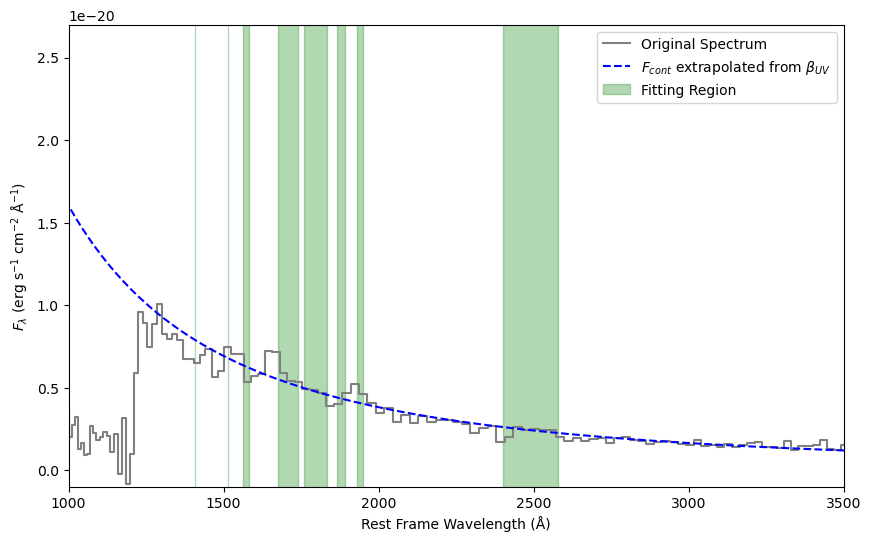

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_13704.spec.fits | LyA Damping Parameter (D_LyA): 36.243
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_5113.spec.fits with redshift z = 5.8183
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.36322711
    reduced chi-square = 0.03026893
    Akaike info crit   = -47.1249807
    Bayesian info crit = -45.8468660
    R-squared          = 0.49017587
[[Variables]]
    beta:         -2.01256811 +/- 0.59250796 (29.44%) (init = -1.5)
    log_FUV_1550: -20.5532259 +/- 0.08942082 (0.44%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8542


100%|██████████| 5000/5000 [00:02<00:00, 2015.76it/s]


β_UV: -2.10 with 16-84 percentile range: [-2.10, -2.10]
log_FUV_1550: -2.05e+01 with 16-84 percentile range: [-2.05e+01, -2.05e+01]


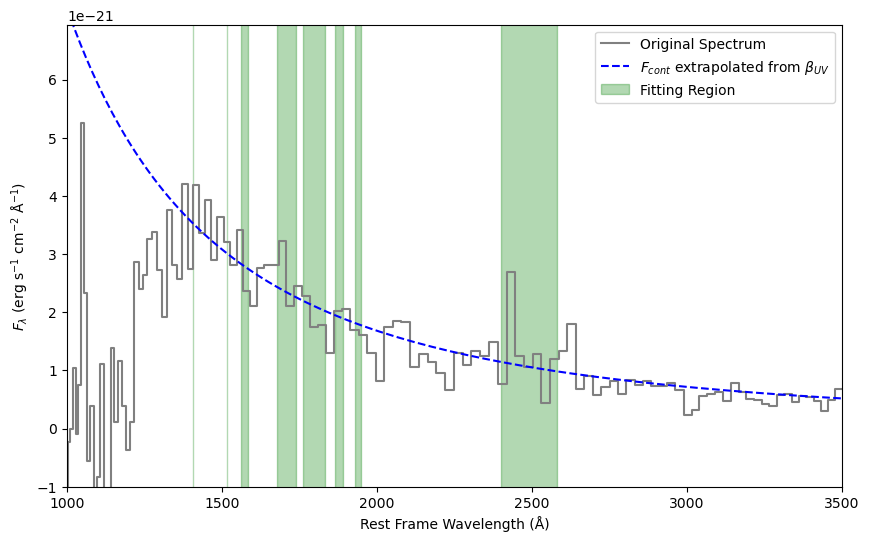

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_5113.spec.fits | LyA Damping Parameter (D_LyA): 75.040
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_8253.spec.fits with redshift z = 6.3295
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.03686705
    reduced chi-square = 0.00283593
    Akaike info crit   = -86.1273094
    Bayesian info crit = -84.7112090
    R-squared          = 0.94589617
[[Variables]]
    beta:         -2.69189703 +/- 0.17855788 (6.63%) (init = -1.5)
    log_FUV_1550: -20.2571175 +/- 0.02654959 (0.13%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8554


100%|██████████| 5000/5000 [00:02<00:00, 2017.62it/s]


β_UV: -2.77 with 16-84 percentile range: [-2.77, -2.77]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


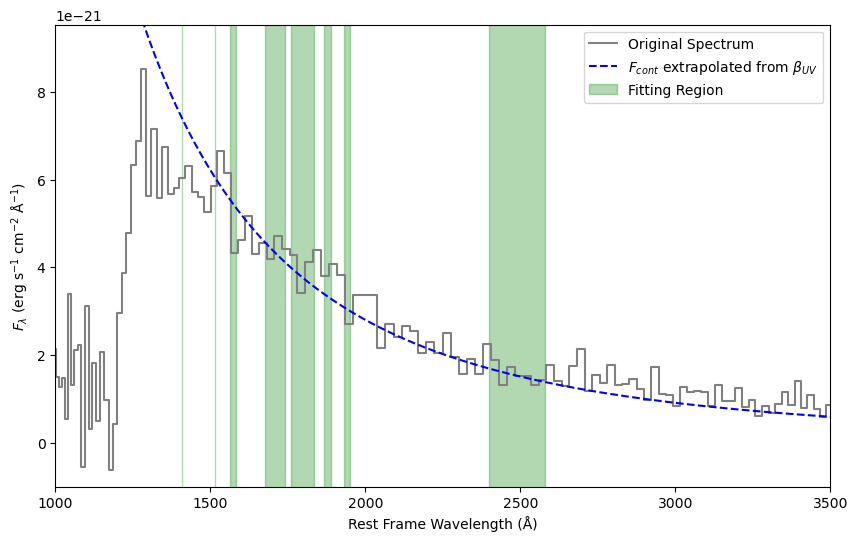

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_8253.spec.fits | LyA Damping Parameter (D_LyA): 62.364
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9414.spec.fits with redshift z = 5.8916
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.08733324
    reduced chi-square = 0.00623809
    Akaike info crit   = -79.3698056
    Bayesian info crit = -77.8246282
    R-squared          = 0.89665832
[[Variables]]
    beta:         -2.81828982 +/- 0.25570894 (9.07%) (init = -1.5)
    log_FUV_1550: -20.2289758 +/- 0.03677656 (0.18%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8436


100%|██████████| 5000/5000 [00:02<00:00, 1998.90it/s]


β_UV: -2.86 with 16-84 percentile range: [-2.86, -2.86]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


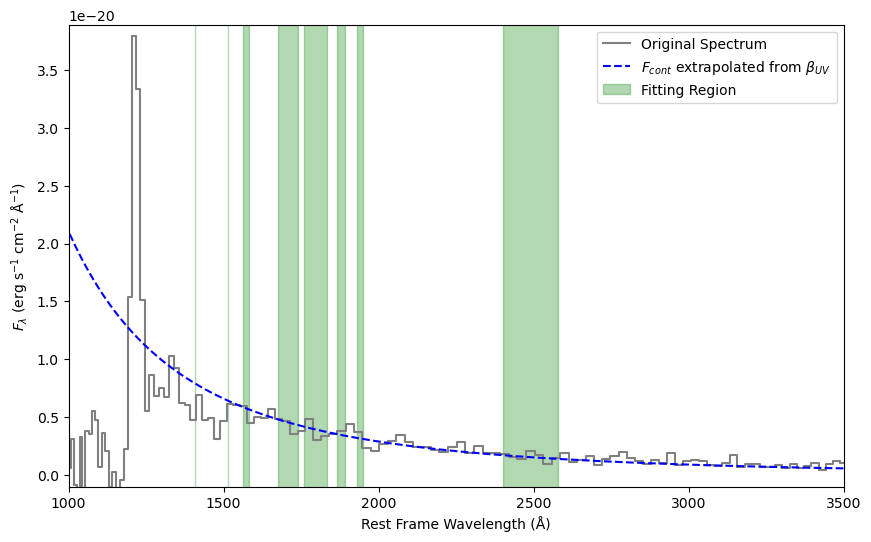

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9414.spec.fits | LyA Damping Parameter (D_LyA): -31.696
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9423.spec.fits with redshift z = 6.3346
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.05153988
    reduced chi-square = 0.00396461
    Akaike info crit   = -81.1017428
    Bayesian info crit = -79.6856424
    R-squared          = 0.90414742
[[Variables]]
    beta:         -2.33787319 +/- 0.21112105 (9.03%) (init = -1.5)
    log_FUV_1550: -20.4056717 +/- 0.03133683 (0.15%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8549


100%|██████████| 5000/5000 [00:02<00:00, 1982.63it/s]


β_UV: -2.32 with 16-84 percentile range: [-2.32, -2.32]
log_FUV_1550: -2.04e+01 with 16-84 percentile range: [-2.04e+01, -2.04e+01]


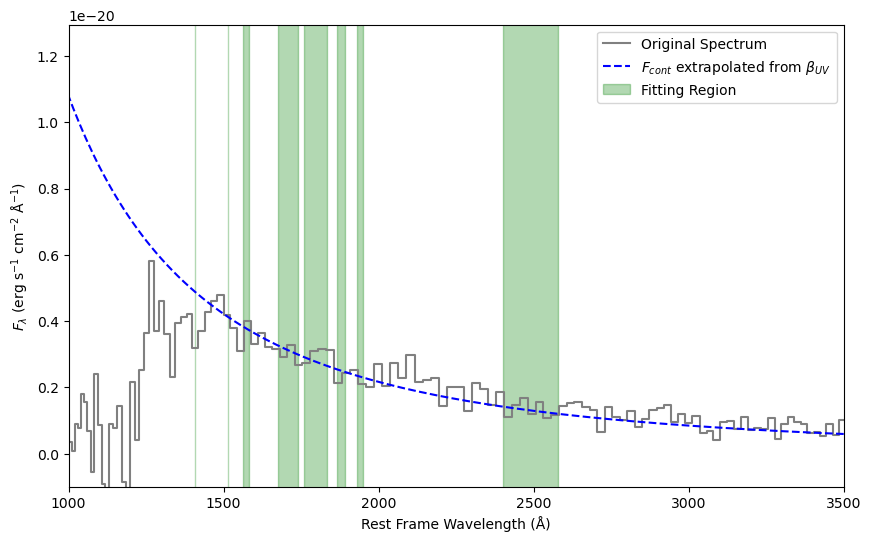

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9423.spec.fits | LyA Damping Parameter (D_LyA): 66.595
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9842.spec.fits with redshift z = 5.8026
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.01114879
    reduced chi-square = 9.2907e-04
    Akaike info crit   = -95.8967392
    Bayesian info crit = -94.6186246
    R-squared          = 0.96562955
[[Variables]]
    beta:         -2.08110650 +/- 0.11334203 (5.45%) (init = -1.5)
    log_FUV_1550: -19.8869120 +/- 0.01744241 (0.09%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8842


100%|██████████| 5000/5000 [00:02<00:00, 1972.56it/s]


β_UV: -2.09 with 16-84 percentile range: [-2.09, -2.09]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


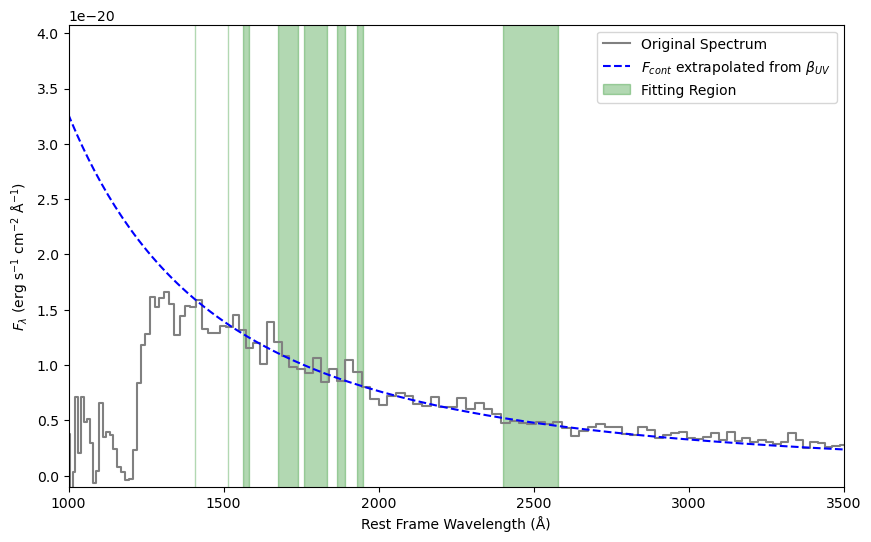

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9842.spec.fits | LyA Damping Parameter (D_LyA): 65.985
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9867.spec.fits with redshift z = 6.105
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.02539093
    reduced chi-square = 0.00211591
    Akaike info crit   = -84.3738856
    Bayesian info crit = -83.0957710
    R-squared          = 0.88891739
[[Variables]]
    beta:         -1.53049896 +/- 0.15618336 (10.20%) (init = -1.5)
    log_FUV_1550: -20.0045300 +/- 0.02370828 (0.12%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8551


100%|██████████| 5000/5000 [00:02<00:00, 2039.90it/s]


β_UV: -1.54 with 16-84 percentile range: [-1.54, -1.54]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


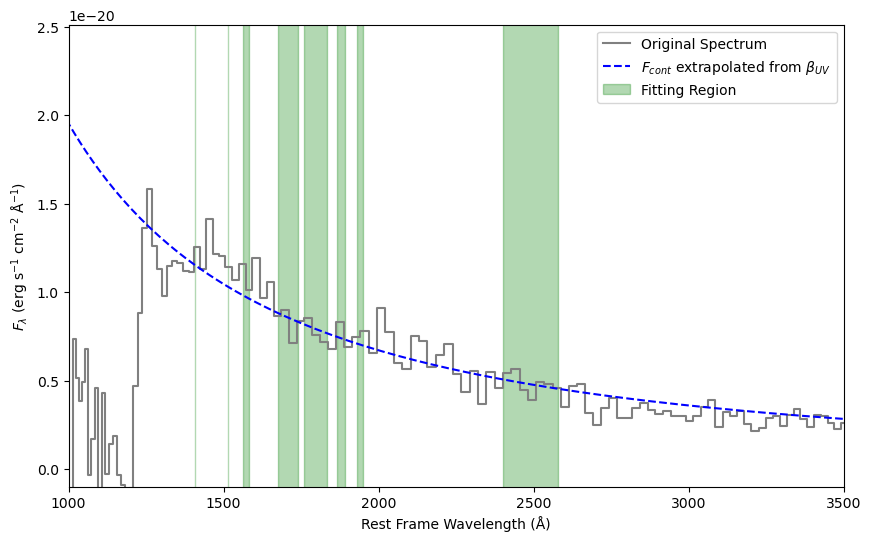

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9867.spec.fits | LyA Damping Parameter (D_LyA): 44.908
Processing DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9880.spec.fits with redshift z = 5.9804
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.05599159
    reduced chi-square = 0.00399940
    Akaike info crit   = -86.4822798
    Bayesian info crit = -84.9371023
    R-squared          = 0.90901763
[[Variables]]
    beta:         -2.44236862 +/- 0.20650932 (8.46%) (init = -1.5)
    log_FUV_1550: -20.2379187 +/- 0.02962742 (0.15%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8457


100%|██████████| 5000/5000 [00:02<00:00, 2025.27it/s]


β_UV: -2.41 with 16-84 percentile range: [-2.41, -2.41]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


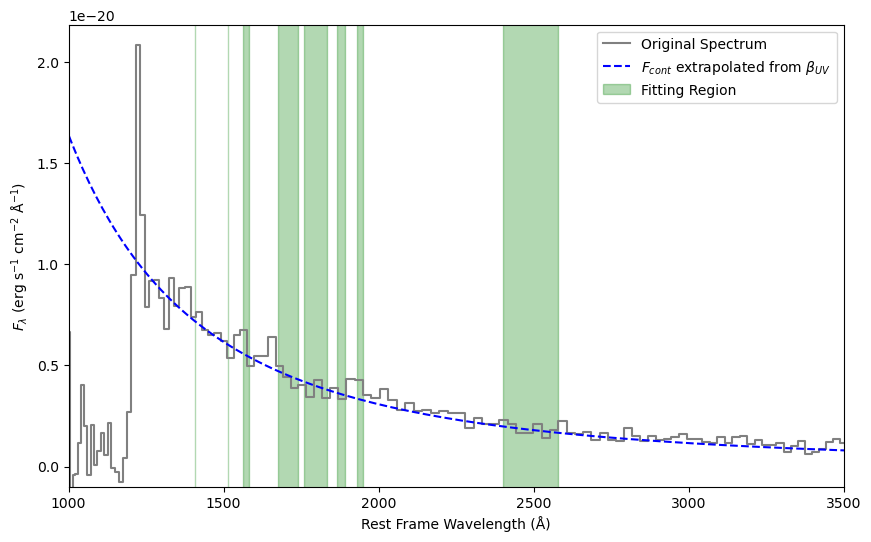

DJA_filtered_58_66/gds-deep-v3_prism-clear_1210_9880.spec.fits | LyA Damping Parameter (D_LyA): 0.928
Processing DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_110627.spec.fits with redshift z = 5.9345
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.03572599
    reduced chi-square = 0.00297717
    Akaike info crit   = -79.5930780
    Bayesian info crit = -78.3149633
    R-squared          = 0.90201318
[[Variables]]
    beta:         -2.01168973 +/- 0.19140257 (9.51%) (init = -1.5)
    log_FUV_1550: -20.0918973 +/- 0.02732591 (0.14%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8457


100%|██████████| 5000/5000 [00:02<00:00, 1973.45it/s]


β_UV: -2.08 with 16-84 percentile range: [-2.08, -2.08]
log_FUV_1550: -2.01e+01 with 16-84 percentile range: [-2.01e+01, -2.01e+01]


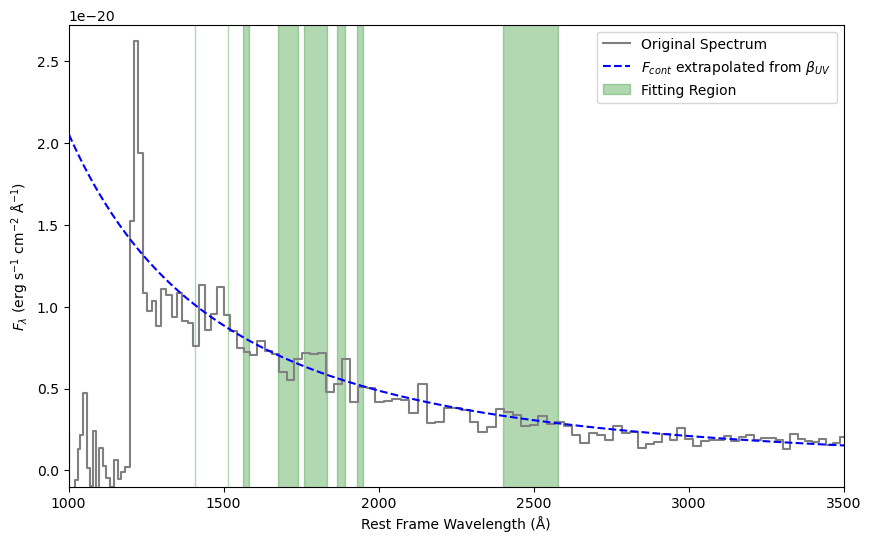

DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_110627.spec.fits | LyA Damping Parameter (D_LyA): 2.355
Processing DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_114613.spec.fits with redshift z = 5.9324
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.03607084
    reduced chi-square = 0.00300590
    Akaike info crit   = -79.4585883
    Bayesian info crit = -78.1804737
    R-squared          = 0.92872072
[[Variables]]
    beta:         -2.40483516 +/- 0.19232413 (8.00%) (init = -1.5)
    log_FUV_1550: -19.8194057 +/- 0.02747887 (0.14%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8460


100%|██████████| 5000/5000 [00:02<00:00, 2008.16it/s]


β_UV: -2.42 with 16-84 percentile range: [-2.42, -2.42]
log_FUV_1550: -1.98e+01 with 16-84 percentile range: [-1.98e+01, -1.98e+01]


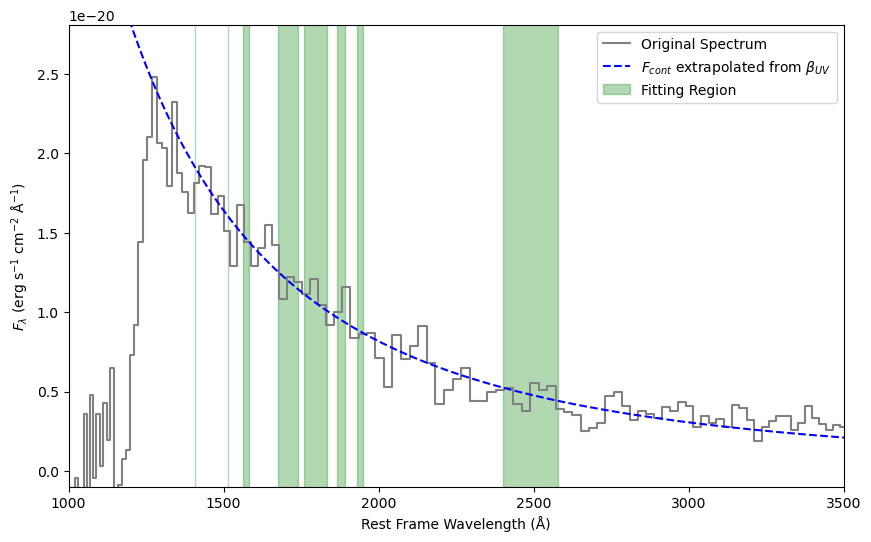

DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_114613.spec.fits | LyA Damping Parameter (D_LyA): 45.278
Processing DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_196541.spec.fits with redshift z = 5.8258
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.01802307
    reduced chi-square = 0.00150192
    Akaike info crit   = -89.1722366
    Bayesian info crit = -87.8941220
    R-squared          = 0.94730512
[[Variables]]
    beta:         -1.93852263 +/- 0.13198346 (6.81%) (init = -1.5)
    log_FUV_1550: -19.8518418 +/- 0.01986504 (0.10%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8533


100%|██████████| 5000/5000 [00:02<00:00, 1987.23it/s]


β_UV: -1.88 with 16-84 percentile range: [-1.88, -1.88]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


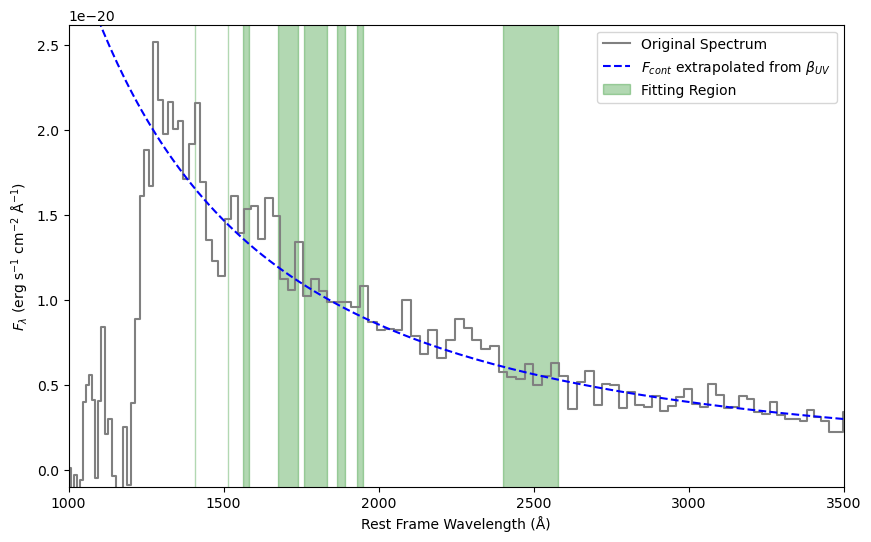

DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_196541.spec.fits | LyA Damping Parameter (D_LyA): 34.424
Processing DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_196770.spec.fits with redshift z = 5.9888
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.14892005
    reduced chi-square = 0.01063715
    Akaike info crit   = -70.8309502
    Bayesian info crit = -69.2857727
    R-squared          = 0.81037360
[[Variables]]
    beta:         -2.60502632 +/- 0.33678664 (12.93%) (init = -1.5)
    log_FUV_1550: -20.0323893 +/- 0.04816933 (0.24%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8447


100%|██████████| 5000/5000 [00:02<00:00, 2021.33it/s]


β_UV: -2.66 with 16-84 percentile range: [-2.66, -2.66]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


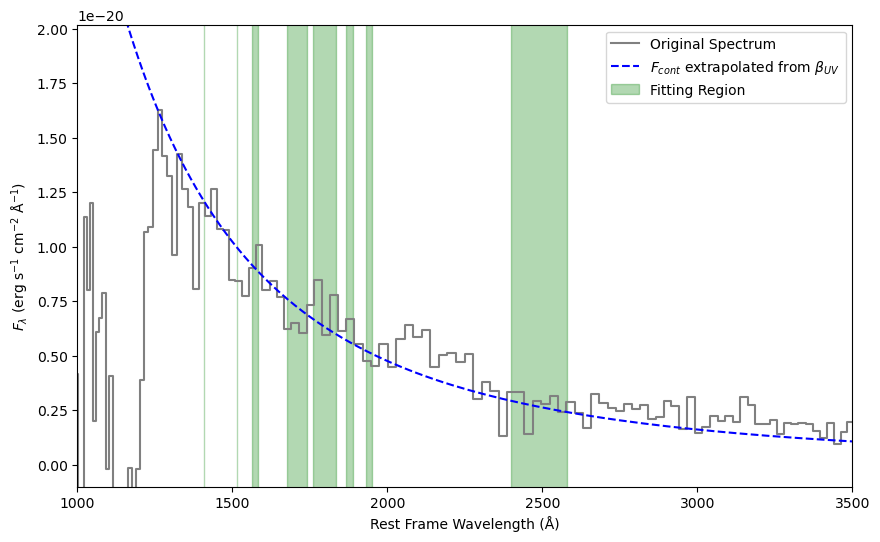

DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_196770.spec.fits | LyA Damping Parameter (D_LyA): 54.721
Processing DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_202754.spec.fits with redshift z = 5.8677
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.05115711
    reduced chi-square = 0.00426309
    Akaike info crit   = -74.5667565
    Bayesian info crit = -73.2886419
    R-squared          = 0.78690255
[[Variables]]
    beta:         -1.50840871 +/- 0.22659851 (15.02%) (init = -1.5)
    log_FUV_1550: -19.9497171 +/- 0.03218559 (0.16%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8403


100%|██████████| 5000/5000 [00:02<00:00, 1959.92it/s]


β_UV: -1.62 with 16-84 percentile range: [-1.62, -1.62]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


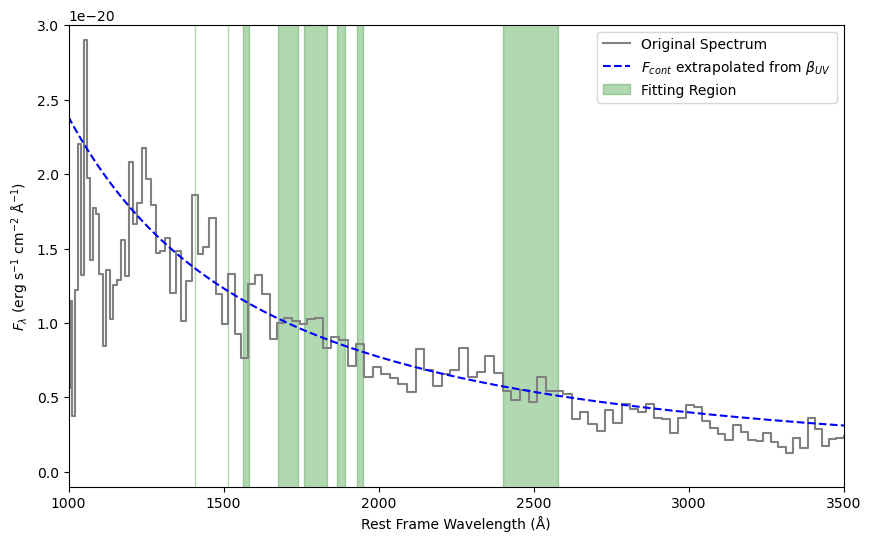

DJA_filtered_58_66/gds-egami-ddt-v3_prism-clear_6541_202754.spec.fits | LyA Damping Parameter (D_LyA): -8.525
Processing DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_201127.spec.fits with redshift z = 5.8353
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.01694847
    reduced chi-square = 0.00141237
    Akaike info crit   = -90.0328916
    Bayesian info crit = -88.7547769
    R-squared          = 0.93556487
[[Variables]]
    beta:         -1.72565902 +/- 0.13073406 (7.58%) (init = -1.5)
    log_FUV_1550: -20.1583330 +/- 0.01878332 (0.09%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8450


100%|██████████| 5000/5000 [00:02<00:00, 2026.37it/s]


β_UV: -1.75 with 16-84 percentile range: [-1.75, -1.75]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


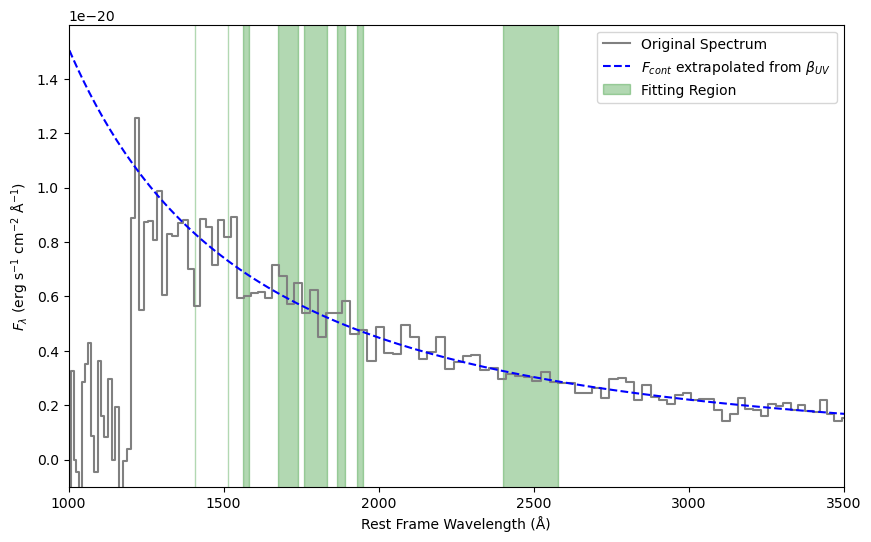

DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_201127.spec.fits | LyA Damping Parameter (D_LyA): 40.745
Processing DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_201850.spec.fits with redshift z = 6.0705
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.10320091
    reduced chi-square = 0.00793853
    Akaike info crit   = -70.6869167
    Bayesian info crit = -69.2708163
    R-squared          = 0.76116740
[[Variables]]
    beta:         -1.94333178 +/- 0.30191312 (15.54%) (init = -1.5)
    log_FUV_1550: -20.5420362 +/- 0.04208304 (0.20%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8374


100%|██████████| 5000/5000 [00:02<00:00, 1970.60it/s]


β_UV: -1.90 with 16-84 percentile range: [-1.90, -1.90]
log_FUV_1550: -2.05e+01 with 16-84 percentile range: [-2.05e+01, -2.05e+01]


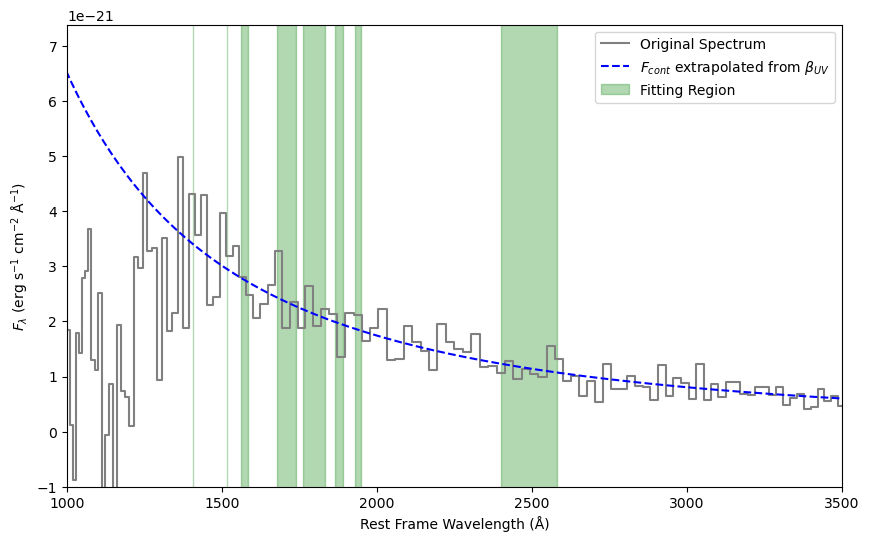

DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_201850.spec.fits | LyA Damping Parameter (D_LyA): 63.133
Processing DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_99302.spec.fits with redshift z = 6.0703
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.03006834
    reduced chi-square = 0.00231295
    Akaike info crit   = -89.1849920
    Bayesian info crit = -87.7688916
    R-squared          = 0.93124181
[[Variables]]
    beta:         -2.16239786 +/- 0.16296522 (7.54%) (init = -1.5)
    log_FUV_1550: -20.4339802 +/- 0.02271706 (0.11%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8374


100%|██████████| 5000/5000 [00:02<00:00, 2015.30it/s]


β_UV: -2.09 with 16-84 percentile range: [-2.09, -2.09]
log_FUV_1550: -2.04e+01 with 16-84 percentile range: [-2.04e+01, -2.04e+01]


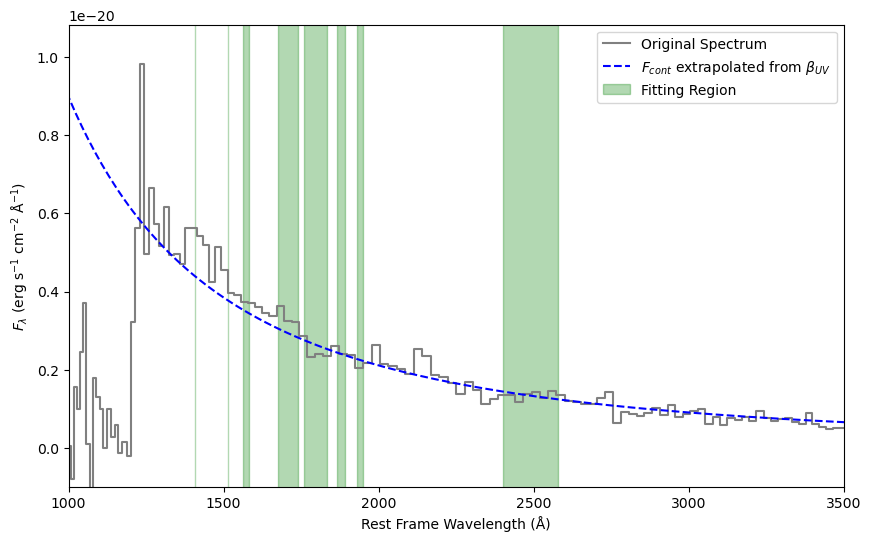

DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_99302.spec.fits | LyA Damping Parameter (D_LyA): 15.421
Processing DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_99671.spec.fits with redshift z = 5.9324
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.02954352
    reduced chi-square = 0.00246196
    Akaike info crit   = -82.2532767
    Bayesian info crit = -80.9751621
    R-squared          = 0.92959584
[[Variables]]
    beta:         -2.19091359 +/- 0.17405508 (7.94%) (init = -1.5)
    log_FUV_1550: -20.4692636 +/- 0.02486863 (0.12%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8460


100%|██████████| 5000/5000 [00:02<00:00, 2009.32it/s]


β_UV: -2.19 with 16-84 percentile range: [-2.19, -2.19]
log_FUV_1550: -2.05e+01 with 16-84 percentile range: [-2.05e+01, -2.05e+01]


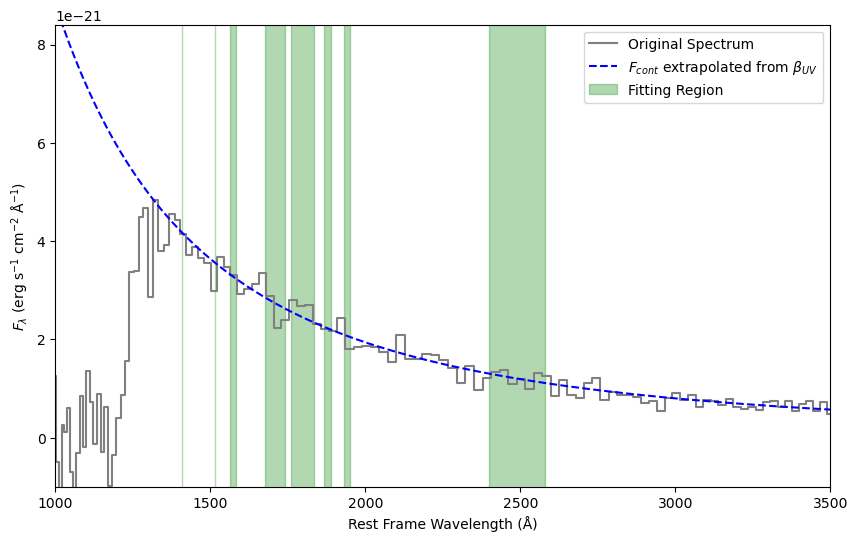

DJA_filtered_58_66/gds-udeep-v3_prism-clear_3215_99671.spec.fits | LyA Damping Parameter (D_LyA): 62.283
Processing DJA_filtered_58_66/jades-gds-wide2-v3_prism-clear_1180_13612.spec.fits with redshift z = 5.9386
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.09446324
    reduced chi-square = 0.00726640
    Akaike info crit   = -72.0139215
    Bayesian info crit = -70.5978211
    R-squared          = 0.85781854
[[Variables]]
    beta:         -2.57590927 +/- 0.29085909 (11.29%) (init = -1.5)
    log_FUV_1550: -19.7299899 +/- 0.04023210 (0.20%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8371


100%|██████████| 5000/5000 [00:02<00:00, 1955.92it/s]


β_UV: -2.67 with 16-84 percentile range: [-2.67, -2.67]
log_FUV_1550: -1.97e+01 with 16-84 percentile range: [-1.97e+01, -1.97e+01]


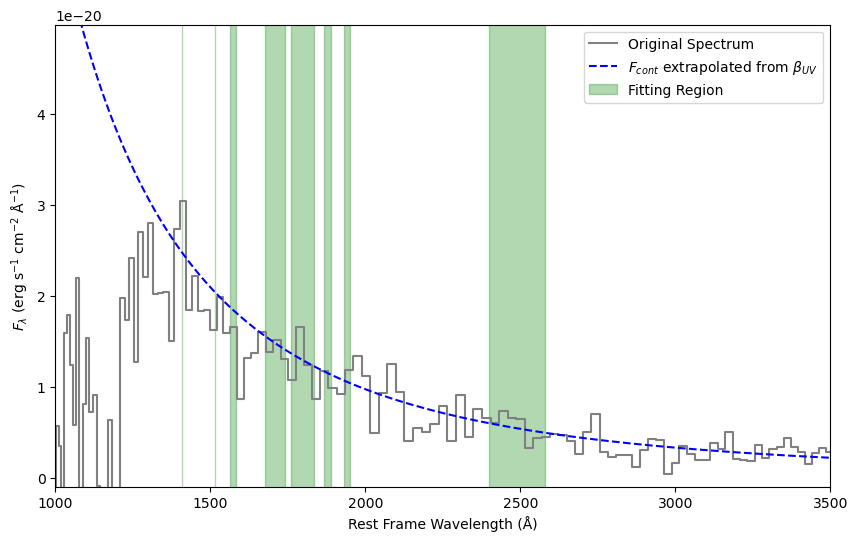

DJA_filtered_58_66/jades-gds-wide2-v3_prism-clear_1180_13612.spec.fits | LyA Damping Parameter (D_LyA): 70.560
Processing DJA_filtered_58_66/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits with redshift z = 5.9137
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.03028485
    reduced chi-square = 0.00275317
    Akaike info crit   = -74.8067422
    Bayesian info crit = -73.6768435
    R-squared          = 0.91947774
[[Variables]]
    beta:         -2.06913082 +/- 0.18462009 (8.92%) (init = -1.5)
    log_FUV_1550: -19.9535184 +/- 0.02707783 (0.14%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8433


100%|██████████| 5000/5000 [00:02<00:00, 2015.01it/s]


β_UV: -2.09 with 16-84 percentile range: [-2.09, -2.09]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


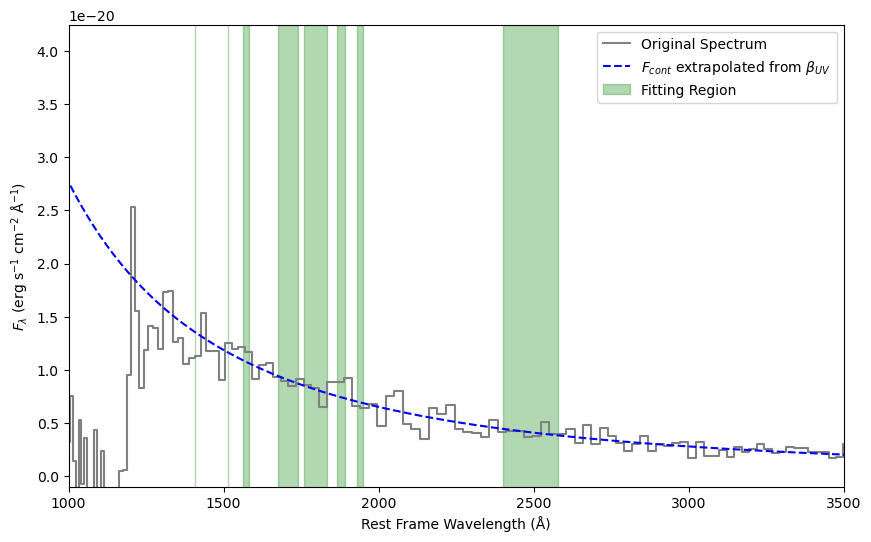

DJA_filtered_58_66/jades-gds-wide2-v3_prism-clear_1180_9698.spec.fits | LyA Damping Parameter (D_LyA): 28.351
Processing DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_13620.spec.fits with redshift z = 5.9192
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.05305570
    reduced chi-square = 0.00482325
    Akaike info crit   = -67.5177101
    Bayesian info crit = -66.3878114
    R-squared          = 0.93117264
[[Variables]]
    beta:         -2.98100824 +/- 0.24436122 (8.20%) (init = -1.5)
    log_FUV_1550: -19.5748079 +/- 0.03576880 (0.18%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8426


100%|██████████| 5000/5000 [00:02<00:00, 2039.69it/s]


β_UV: -3.10 with 16-84 percentile range: [-3.10, -3.10]
log_FUV_1550: -1.96e+01 with 16-84 percentile range: [-1.96e+01, -1.96e+01]


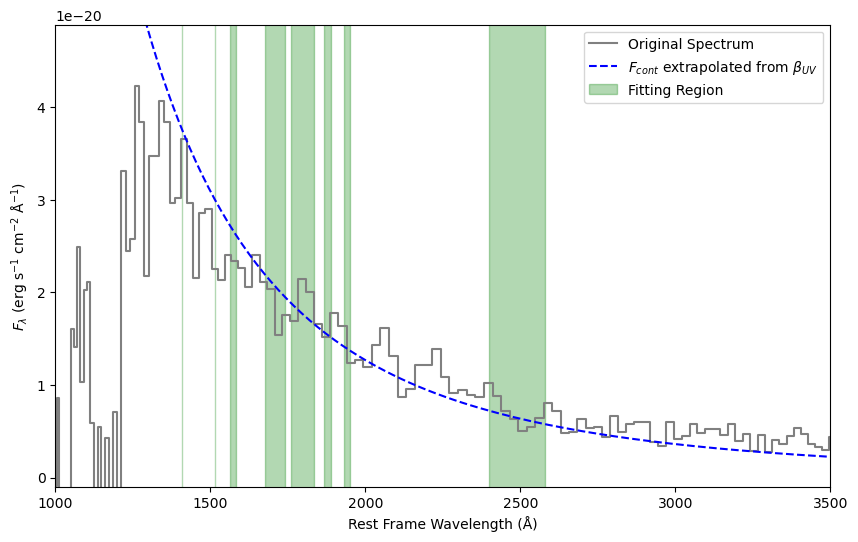

DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_13620.spec.fits | LyA Damping Parameter (D_LyA): 69.475
Processing DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_13638.spec.fits with redshift z = 5.8285
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.04175634
    reduced chi-square = 0.00347969
    Akaike info crit   = -77.4094594
    Bayesian info crit = -76.1313447
    R-squared          = 0.90148137
[[Variables]]
    beta:         -2.10511622 +/- 0.20089367 (9.54%) (init = -1.5)
    log_FUV_1550: -19.7285428 +/- 0.03020738 (0.15%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8530


100%|██████████| 5000/5000 [00:02<00:00, 2024.31it/s]


β_UV: -2.14 with 16-84 percentile range: [-2.14, -2.14]
log_FUV_1550: -1.97e+01 with 16-84 percentile range: [-1.97e+01, -1.97e+01]


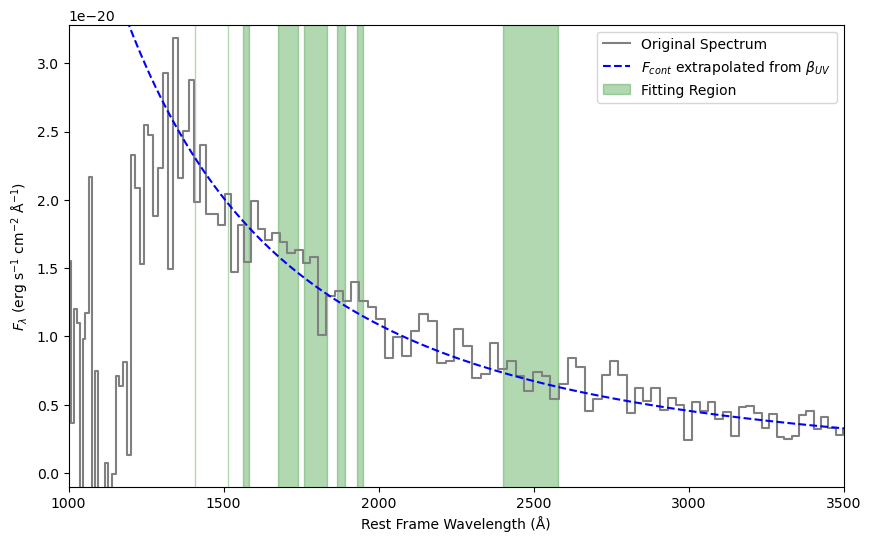

DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_13638.spec.fits | LyA Damping Parameter (D_LyA): 49.870
Processing DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_14160.spec.fits with redshift z = 6.3141
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.08131914
    reduced chi-square = 0.00677660
    Akaike info crit   = -68.0780359
    Bayesian info crit = -66.7999212
    R-squared          = 0.86330288
[[Variables]]
    beta:         -2.41446617 +/- 0.27735026 (11.49%) (init = -1.5)
    log_FUV_1550: -19.9719776 +/- 0.04226711 (0.21%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8538


100%|██████████| 5000/5000 [00:02<00:00, 1989.73it/s]


β_UV: -2.40 with 16-84 percentile range: [-2.40, -2.40]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


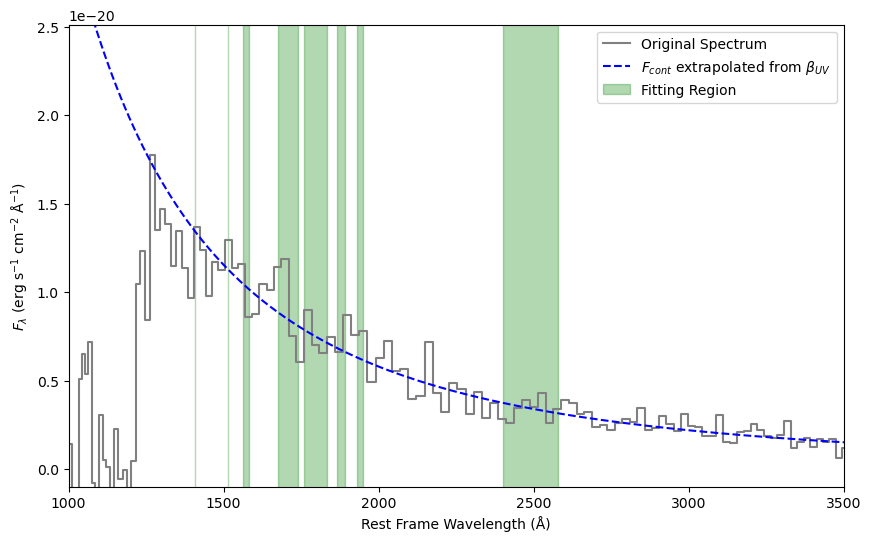

DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_14160.spec.fits | LyA Damping Parameter (D_LyA): 66.666
Processing DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits with redshift z = 5.9172
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.12293118
    reduced chi-square = 0.01117556
    Akaike info crit   = -56.5940395
    Bayesian info crit = -55.4641408
    R-squared          = 0.79121717
[[Variables]]
    beta:         -2.40156356 +/- 0.37196089 (15.49%) (init = -1.5)
    log_FUV_1550: -19.8582514 +/- 0.05448578 (0.27%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8429


100%|██████████| 5000/5000 [00:02<00:00, 2012.54it/s]


β_UV: -2.45 with 16-84 percentile range: [-2.45, -2.45]
log_FUV_1550: -1.99e+01 with 16-84 percentile range: [-1.99e+01, -1.99e+01]


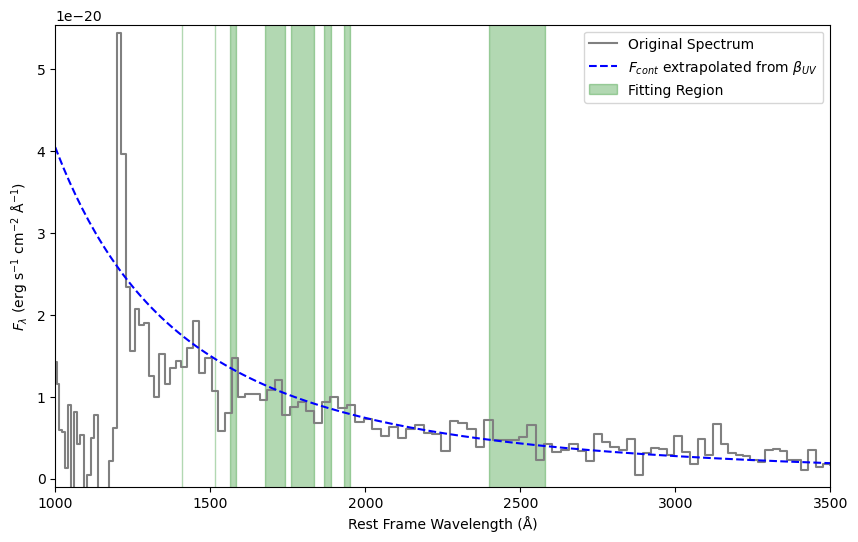

DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9365.spec.fits | LyA Damping Parameter (D_LyA): 3.801
Processing DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9696.spec.fits with redshift z = 5.8627
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.54884468
    reduced chi-square = 0.04573706
    Akaike info crit   = -41.3459598
    Bayesian info crit = -40.0678451
    R-squared          = 0.63956028
[[Variables]]
    beta:         -3.42486797 +/- 0.74221340 (21.67%) (init = -1.5)
    log_FUV_1550: -20.0631971 +/- 0.10561980 (0.53%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8409


100%|██████████| 5000/5000 [00:02<00:00, 2021.09it/s]


β_UV: -3.81 with 16-84 percentile range: [-3.81, -3.81]
log_FUV_1550: -2.00e+01 with 16-84 percentile range: [-2.00e+01, -2.00e+01]


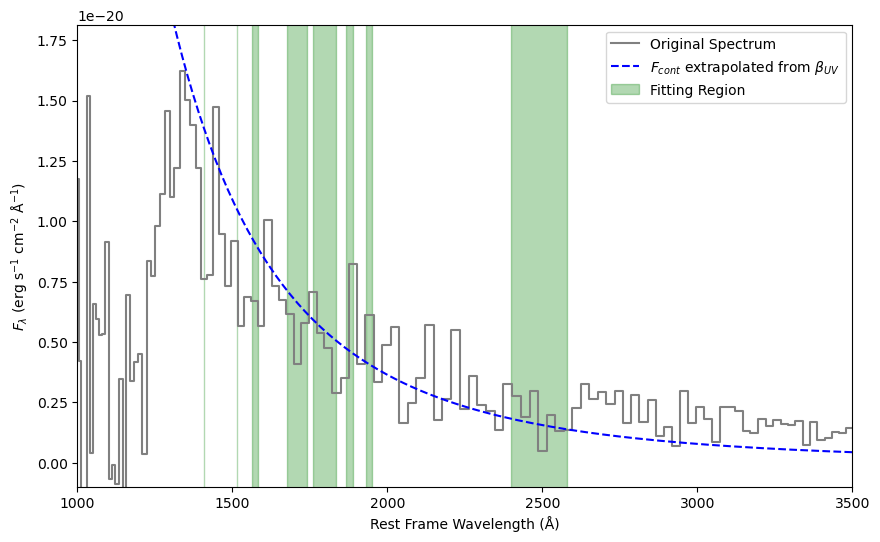

DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9696.spec.fits | LyA Damping Parameter (D_LyA): 77.151
Processing DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9697.spec.fits with redshift z = 5.9331
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.64221014
    reduced chi-square = 0.05351751
    Akaike info crit   = -39.1465584
    Bayesian info crit = -37.8684438
    R-squared          = 0.40553339
[[Variables]]
    beta:         -2.32185131 +/- 0.81151061 (34.95%) (init = -1.5)
    log_FUV_1550: -20.0202252 +/- 0.11591685 (0.58%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8459


100%|██████████| 5000/5000 [00:02<00:00, 2004.15it/s]


β_UV: -2.12 with 16-84 percentile range: [-2.12, -2.12]
log_FUV_1550: -2.01e+01 with 16-84 percentile range: [-2.01e+01, -2.01e+01]


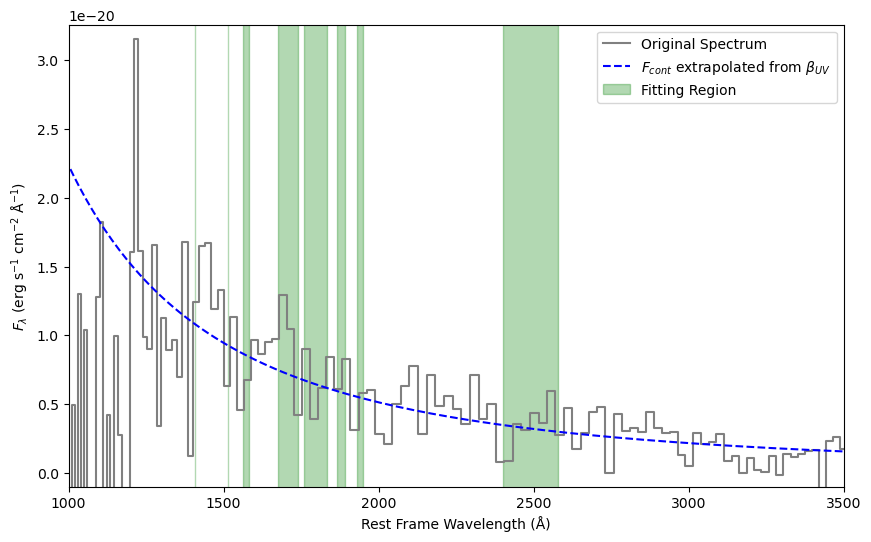

DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9697.spec.fits | LyA Damping Parameter (D_LyA): 21.926
Processing DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9877.spec.fits with redshift z = 6.1015
0 NaNs in log_flux
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 2
    chi-square         = 0.03097489
    reduced chi-square = 0.00258124
    Akaike info crit   = -81.5908990
    Bayesian info crit = -80.3127844
    R-squared          = 0.93467097
[[Variables]]
    beta:         -2.26030585 +/- 0.17250446 (7.63%) (init = -1.5)
    log_FUV_1550: -19.4572932 +/- 0.02621736 (0.13%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8554


100%|██████████| 5000/5000 [00:02<00:00, 1994.75it/s]


β_UV: -2.27 with 16-84 percentile range: [-2.27, -2.27]
log_FUV_1550: -1.95e+01 with 16-84 percentile range: [-1.95e+01, -1.95e+01]


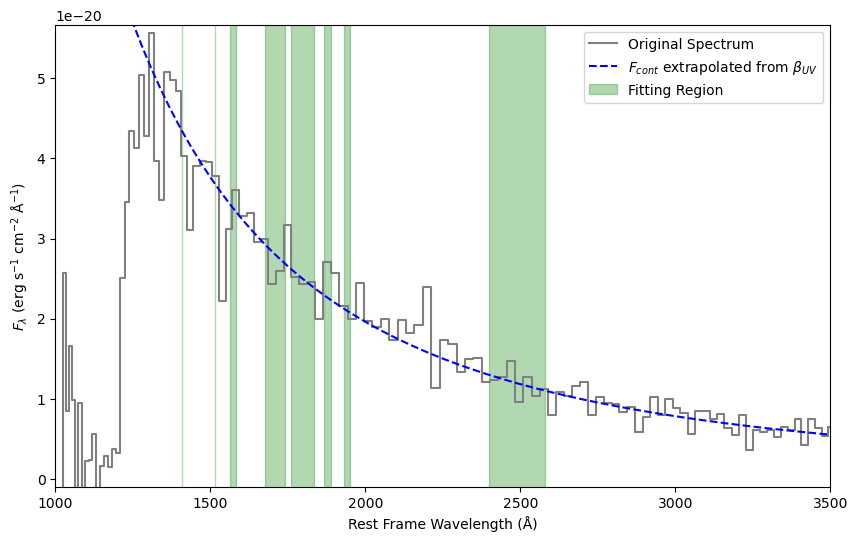

DJA_filtered_58_66/jades-gds-wide-v3_prism-clear_1180_9877.spec.fits | LyA Damping Parameter (D_LyA): 53.502

Summary of Results as Table:
                     File Name                      ... LyA Damping Parameter
--------------------------------------------------- ... ---------------------
       gds-deep-v3_prism-clear_1210_13176.spec.fits ...     45.91339619218137
       gds-deep-v3_prism-clear_1210_13197.spec.fits ...    15.671935420116153
       gds-deep-v3_prism-clear_1210_13618.spec.fits ...    52.283776820087084
       gds-deep-v3_prism-clear_1210_13620.spec.fits ...     47.51041321816963
       gds-deep-v3_prism-clear_1210_13704.spec.fits ...      36.2431320751821
        gds-deep-v3_prism-clear_1210_5113.spec.fits ...     75.03982587135103
        gds-deep-v3_prism-clear_1210_8253.spec.fits ...    62.363606265371786
        gds-deep-v3_prism-clear_1210_9414.spec.fits ...   -31.696314166575462
        gds-deep-v3_prism-clear_1210_9423.spec.fits ...     66.59503536774483
   

In [33]:
results_table = process_spectra(filtered_table, folder_name=set)

In [34]:
results_table

File Name,z_spec,B_UV,LyA Damping Parameter
str51,float64,float64,float64
gds-deep-v3_prism-clear_1210_13176.spec.fits,5.9407,-2.3806568674636357,45.91339619218137
gds-deep-v3_prism-clear_1210_13197.spec.fits,6.342,-2.344754852428585,15.671935420116153
gds-deep-v3_prism-clear_1210_13618.spec.fits,5.9484,-1.8592085676925367,52.283776820087084
gds-deep-v3_prism-clear_1210_13620.spec.fits,5.9199,-2.760907341703945,47.51041321816963
gds-deep-v3_prism-clear_1210_13704.spec.fits,5.9296,-2.0691123275555654,36.2431320751821
gds-deep-v3_prism-clear_1210_5113.spec.fits,5.8183,-2.103557853854677,75.03982587135103
gds-deep-v3_prism-clear_1210_8253.spec.fits,6.3295,-2.767391607373665,62.363606265371786
gds-deep-v3_prism-clear_1210_9414.spec.fits,5.8916,-2.856125841369296,-31.696314166575462
gds-deep-v3_prism-clear_1210_9423.spec.fits,6.3346,-2.3165818855166664,66.59503536774483


In [35]:
print(np.min(results_table['B_UV']), np.max(results_table['B_UV']))

-3.8113854096086572 -1.5402377942314143


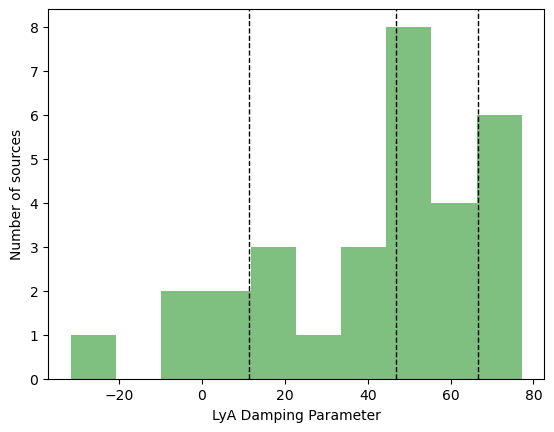

In [38]:
# plot histogram of lya damping parameter
plt.hist(results_table['LyA Damping Parameter'], bins=10, color='green', alpha=0.5)
plt.xlabel('LyA Damping Parameter')
plt.ylabel('Number of sources')
# plot vertical lines at percentiles 16, 50 and 84
plt.axvline(np.percentile(results_table['LyA Damping Parameter'], 16), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(results_table['LyA Damping Parameter'], 50), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(results_table['LyA Damping Parameter'], 84), color='black', linestyle='dashed', linewidth=1)



In [ ]:
# Main analysis pipeline
def analyze_uv_spectrum(wavelength, flux, flux_err, beta=-2.0, log_FUV_1550=np.log10(1e-15)):

    # Mask to fitting region
    wavelength_masked, flux_masked, flux_err_masked, regions = mask_wavelength_region(wavelength, flux, flux_err)
    
    # Log transformation
    log_wavelength, log_flux = log_transform(wavelength_masked, flux_masked)

    print(np.isnan(log_flux).sum(), "NaNs in log_flux")
    print(np.isnan(log_wavelength).sum(), "NaNs in log_wavelength")

    # Interpolate NaN values in the flux using linear interpolation (or another method if needed)
    if np.any(np.isnan(log_flux)):
        # Identify the indices where flux is NaN
        nan_indices = np.isnan(log_flux)

        # Create an interpolation function based on non-NaN values
        valid_indices = ~nan_indices
        interp_func = interpolate.interp1d(log_wavelength[valid_indices], log_flux[valid_indices], kind='linear', fill_value='extrapolate')

        # Interpolate the NaN values
        log_flux[nan_indices] = interp_func(log_wavelength[nan_indices])
      
    # Initial fit
    result = initial_fit(log_wavelength, log_flux, beta, log_FUV_1550)
    
    # MCMC sampling
    samples = run_mcmc(log_wavelength, log_flux, flux_err_masked, result)
    
    # MCMC results
    beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci  = get_mcmc_results(samples)
    
    # Plotting
    #plot_spectrum(wavelength, flux, regions)

    return wavelength_masked, flux_masked, regions ,beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci


Processing /Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_265801.spec.fits with redshift z = 9.4383
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 23
    # variables        = 2
    chi-square         = 0.00677912
    reduced chi-square = 3.2282e-04
    Akaike info crit   = -182.976257
    Bayesian info crit = -180.705268
    R-squared          = 0.99288690
[[Variables]]
    beta:         -2.62835545 +/- 0.04854606 (1.85%) (init = -1.5)
    log_FUV_1550: -20.1641859 +/- 0.00750709 (0.04%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8666


100%|██████████| 5000/5000 [00:03<00:00, 1470.77it/s]


β_UV: -2.63 with 16-84 percentile range: [-2.63, -2.63]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


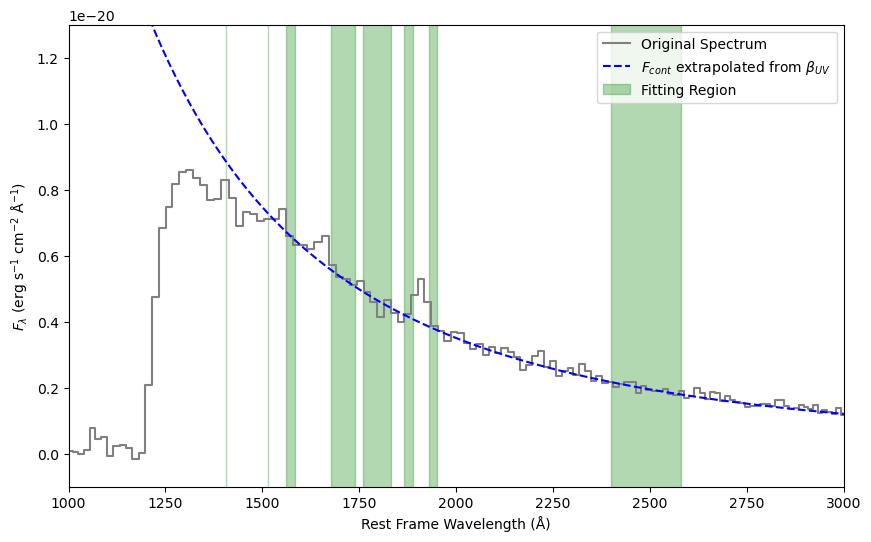

/Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_265801.spec.fits | LyA Damping Parameter (D_LyA): 65.171
Processing /Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_113056.spec.fits with redshift z = 5.9937
Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 0.12756760
    reduced chi-square = 0.00981289
    Akaike info crit   = -67.5073860
    Bayesian info crit = -66.0912856
    R-squared          = 0.74716127
[[Variables]]
    beta:         -2.06171138 +/- 0.33263720 (16.13%) (init = -1.5)
    log_FUV_1550: -20.6942871 +/- 0.04626516 (0.22%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8333


100%|██████████| 5000/5000 [00:03<00:00, 1479.50it/s]


β_UV: -1.90 with 16-84 percentile range: [-1.90, -1.90]
log_FUV_1550: -2.07e+01 with 16-84 percentile range: [-2.07e+01, -2.07e+01]


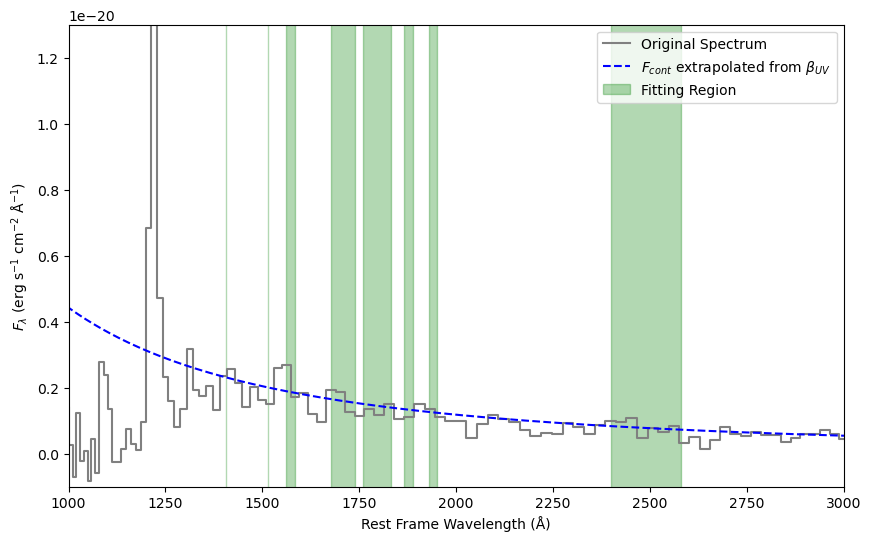

/Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_113056.spec.fits | LyA Damping Parameter (D_LyA): -32.169
Processing /Users/s2537809/MUSE/DJA_Mosaic/gds-deep-v3_g140m-f070lp_1210_10642.spec.fits with redshift z = 1.9033


/Users/s2537809/MUSE/NIRSpec.py:89: RuntimeWarning: invalid value encountered in log10
  return np.log10(wavelength), np.log10(flux)


ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [ ]:


def process_spectra(table, folder_name):
    # Output arrays
    file_names = []
    redshift_values = []
    damping_parameters = []
    b_uv_values = []

    # Loop through each row and process
    for row in table:
        filename = row['file']
        filepath = os.path.join(folder_name, filename)
        z = row['z_spec']

        print(f"Processing {filepath} with redshift z = {z}")
        process_spectrum(filepath, z)

    # Create an Astropy Table from the results
    results_table = Table([file_names, redshift_values, b_uv_values, damping_parameters], 
                          names=('File Name', 'z_spec', 'B_UV', 'LyA Damping Parameter'))

    # Save the results table to a file
    results_table.write('spectrum_analysis_results.fits', format='fits', overwrite=True)

    # Display or save the results table
    print("\nSummary of Results as Table:")
    print(results_table)




# Constants
c = 3e18  # Speed of light in Å/s


# Redshift

#z= 9.4383 # paper
#z = 9.4385 # DJA
#z = 5.9440 # paper
#z= 5.9937 #DJA

# /Users/s2537809/MUSE/DJA_Mosaic/gds-deep-v3_g140m-f070lp_1210_10642.spec.fits

# Define redshifts for each spectrum
redshifts = {
    '/Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_265801.spec.fits': 9.4383,
    '/Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_113056.spec.fits': 5.9937,
    '/Users/s2537809/MUSE/DJA_Mosaic/gds-deep-v3_g140m-f070lp_1210_10642.spec.fits': 1.9033,
}

# Output arrays
file_names = []
redshift_values = []
damping_parameters = []
b_uv_values = [] 

def process_spectrum(filepath, z):
    # Load the data
    tab = Table.read(filepath, format='fits')

    # Extract filename from filepath
    filename = os.path.basename(filepath)
    
    # Convert wavelength from microns to angstroms
    wavelengths_microns = tab['wave']
    wavelengths_angstroms = wavelengths_microns.to(u.AA)
    
    # Convert flux to erg/s/cm^2/Å
    flux_microjy = tab['flux']
    flux_err_microjy = tab['err']
    flux_erg_per_s_cm2_A = flux_microjy.to(u.erg / (u.s * u.cm**2 * u.AA), equivalencies=u.spectral_density(wavelengths_angstroms))
    flux_err_erg_per_s_cm2_A = flux_err_microjy.to(u.erg / (u.s * u.cm**2 * u.AA), equivalencies=u.spectral_density(wavelengths_angstroms))
    
    # Add rest-frame wavelength
    rest_wave_angstroms = wavelengths_angstroms / (1 + z)
    
    # Perform UV spectrum analysis
    wavelength_masked, flux_masked, regions, beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci = analyze_uv_spectrum(
        rest_wave_angstroms.value, 
        flux_erg_per_s_cm2_A.value, 
        flux_err_erg_per_s_cm2_A.value,
        beta=-1.5, 
        log_FUV_1550=np.log10(1e-15)
    )

    # Extrapolate continuum and plot
    f_cont = extrapolate_continuum(rest_wave_angstroms.value, beta_median, log_FUV_1550_median)
    plot_spectrum_with_continuum(rest_wave_angstroms.value, flux_erg_per_s_cm2_A.value, f_cont, regions)
    
    # Calculate D_LyA - note this has OBSEREVED wavelengths
    DLyA = calculate_damping_parameter(wavelengths_angstroms.value, flux_erg_per_s_cm2_A.value, f_cont, z)
    print(f"{filepath} | LyA Damping Parameter (D_LyA): {DLyA:.3f}")

    # Append results to the output arrays
    file_names.append(filename)
    redshift_values.append(z)
    damping_parameters.append(DLyA)
    b_uv_values.append(beta_median)

# Loop through each file and process
for filepath, z in redshifts.items():
    print(f"Processing {filepath} with redshift z = {z}")
    process_spectrum(filepath, z)

# Create an Astropy Table from the results
results_table = Table([file_names, redshift_values,b_uv_values, damping_parameters], 
                      names=('File Name', 'z_spec', 'B_UV','LyA Damping Parameter'))

# Save the results table to a file
results_table.write('spectrum_analysis_results.fits', format='fits', overwrite=True)

# Display or save the results table
print("\nSummary of Results as Table:")
results_table

In [6]:

#filepath = '/Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_265801.spec.fits'
filepath = '/Users/s2537809/Downloads/cosmos-transients-v3_prism-clear_6585_11272.spec.fits'
#filepath = '/Users/s2537809/Downloads/jades-gds-wide2-v3_prism-clear_1180_105840.spec.fits'
#filepath = '/Users/s2537809/Downloads/gds-udeep-v3_prism-clear_3215_113056.spec.fits'
filepath = '/Users/s2537809/MUSE/practice_sample/rubies-egs61-nod-v3_prism-clear_4233_58197.spec.fits'
filepth = '/Users/s2537809/MUSE/practice_sample/gds-egami-ddt-v3_prism-clear_6541_-176.spec.fits'


tab = Table.read(filepath, format='fits')

tab

# Redshift

z= 9.4383 # paper
#z = 9.4385 # DJA
#z = 5.9440 # paper
#z= 5.9937 #DJA


In [9]:
#np.array(tab['flux'])
#
print(len(tab['wave']))

435


In [20]:
wavelengths = tab['wave']
flux = tab['flux'].value
flux_err = tab['err']
min_wavelength = 2.0
max_wavelength = 4.5

# print flux at min and max wavelength
min_flux = flux[np.where(wavelengths == min_wavelength)]
max_flux = flux[np.where(wavelengths == max_wavelength)]
print ('min flu x=', min_flux)

valid_range_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))
                
# Check for NaN values within the specified range
if np.any(np.isnan(flux[valid_range_indices])):
    print("Warning: NaN values found in the flux array within the specified wavelength range.")
    flux = ma.masked_invalid(flux)
    flux_err = ma.masked_invalid(flux_err)

min flu x= []


In [22]:
import numpy as np
import numpy.ma as ma

# Indices of closest wavelength values to min and max
min_index = np.argmin(np.abs(wavelengths - min_wavelength))
max_index = np.argmin(np.abs(wavelengths - max_wavelength))

# Check values at min and max indices
min_flux = flux[min_index]
max_flux = flux[max_index]

print("Min flux =", min_flux)
print("Max flux =", max_flux)

# If min_flux is masked or NaN, try finding a nearby valid value within a tolerance range
tolerance = 0.05  # in microns, adjust as needed
if np.isnan(min_flux) or np.ma.is_masked(min_flux):
    # Find the nearest valid flux value within the tolerance range
    nearby_indices = np.where((wavelengths >= min_wavelength - tolerance) & 
                              (wavelengths <= min_wavelength + tolerance) & 
                              ~np.isnan(flux))[0]
    if len(nearby_indices) > 0:
        min_flux = flux[nearby_indices[0]]
        print("Adjusted min flux =", min_flux)
    else:
        print("No valid flux found near min wavelength.")

# Mask invalid values within the specified wavelength range
valid_range_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))
if np.any(np.isnan(flux[valid_range_indices])):
    print("Warning: NaN values found in flux within the specified range.")
    flux = ma.masked_invalid(flux)
    flux_err = ma.masked_invalid(flux_err)

    flux_err = ma.masked_invalid(flux_err)


Min flux = --
Max flux = 0.08816122650440827
No valid flux found near min wavelength.


In [11]:
np.array(tab['wave'])
#print(len(tab['wave']))

array([0.58      , 0.58368511, 0.58743788, 0.59126022, 0.59515426,
       0.59912194, 0.60316525, 0.60728664, 0.61148833, 0.61577259,
       0.62014179, 0.62459864, 0.62914577, 0.63378584, 0.63852165,
       0.6433561 , 0.6482922 , 0.65333313, 0.6584822 , 0.66374277,
       0.66911831, 0.67461243, 0.68022885, 0.68597146, 0.69184423,
       0.6978513 , 0.70399693, 0.71028561, 0.71672191, 0.72331053,
       0.73005628, 0.73696412, 0.7440392 , 0.75128688, 0.75871251,
       0.76632159, 0.77411992, 0.7821132 , 0.79030739, 0.79870847,
       0.80732254, 0.81615575, 0.82521435, 0.83450455, 0.8440326 ,
       0.85380473, 0.8638271 , 0.87410579, 0.88464675, 0.89545572,
       0.90653824, 0.9178996 , 0.92954474, 0.94147818, 0.95370401,
       0.96622584, 0.97904675, 0.99216917, 1.00559465, 1.01932434,
       1.03335816, 1.04769562, 1.06233481, 1.07727331, 1.09250762,
       1.10803299, 1.12384392, 1.13993392, 1.15629547, 1.17292011,
       1.18979848, 1.20692039, 1.2242749 , 1.2418504 , 1.25963

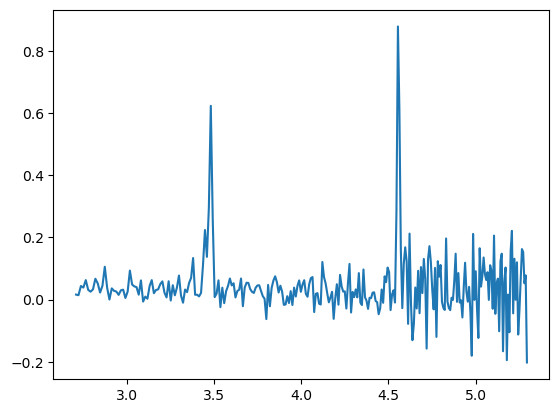

In [12]:
#plot wave and flux

plt.plot(tab['wave'], tab['flux'])

In [4]:
# print flux range 
print('Flux range: ', np.min(tab['flux']), np.max(tab['flux']))

Flux range:  -0.007672857145876609 2.394144907496262


angstrom observed: 5799.999999999998 Angstrom 53366.181712699516 Angstrom
micron observed: 0.58 5.3366181712699525
angstrom rest: 555.6460343159325 Angstrom 5112.535730214644 Angstrom
micron rest: 0.055564603431593265 0.5112535730214645


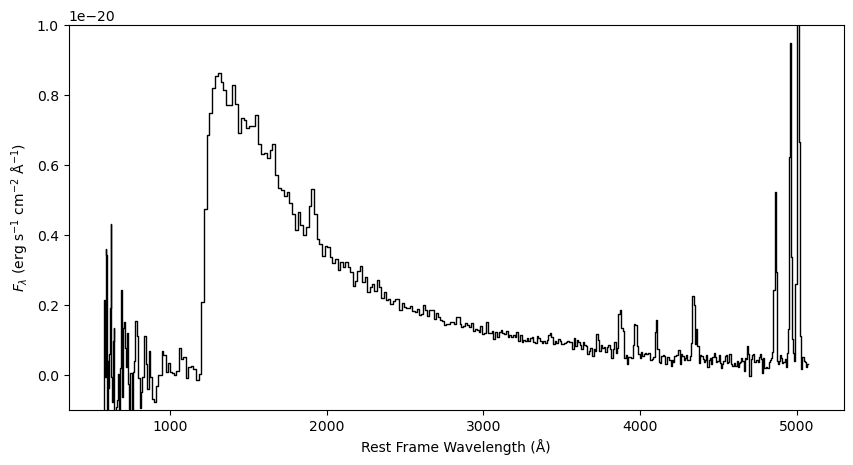

In [5]:
# convert data

# Constants
c = 3e18  # Speed of light in Å/s


# Convert wavelength from microns (µm) to angstroms (Å)
wavelengths_microns = tab['wave']  # Wavelengths in µm
wavelengths_angstroms = wavelengths_microns.to(u.AA)  # Convert to Å

# print wavelength ranges 
print("angstrom observed:",wavelengths_angstroms.min(), wavelengths_angstroms.max())
print("micron observed:",wavelengths_microns.min(), wavelengths_microns.max())

# Flux in µJy
flux_microjy = tab['flux'] # Flux in µJy
flux_err_microjy = tab['err']   # Error in flux in µJy


# Convert flux array to erg/s/cm^2/Å using spectral density equivalency for each wavelength
flux_erg_per_s_cm2_A = flux_microjy.to(u.erg / (u.s * u.cm**2 * u.AA), equivalencies=u.spectral_density(wavelengths_angstroms))
flux_err_erg_per_s_cm2_A = flux_err_microjy.to(u.erg / (u.s * u.cm**2 * u.AA), equivalencies=u.spectral_density(wavelengths_angstroms))


tab['wave_angstroms'] = wavelengths_angstroms
tab['flux_erg_per_s_cm2_A'] = flux_erg_per_s_cm2_A
tab['flux_err_erg_per_s_cm2_A'] = flux_err_erg_per_s_cm2_A


# Convert observed wavelength to rest-frame wavelength
rest_wave_microns = wavelengths_microns / (1 + z)
rest_wave_angstroms = wavelengths_angstroms / (1 + z)

# print wavelength ranges
print("angstrom rest:",rest_wave_angstroms.min(), rest_wave_angstroms.max())
print("micron rest:",rest_wave_microns.min(), rest_wave_microns.max())


# Plotting the data using the rest-frame wavelength
plt.figure(figsize=(10, 5))
plt.plot(rest_wave_angstroms, tab['flux_erg_per_s_cm2_A'], color='black', lw=1, drawstyle='steps-mid')
plt.xlabel('Rest Frame Wavelength (Å)')  
# f subscript lambda label
plt.ylabel(r'$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
#plt.xlim(800, 5500)  
plt.ylim(-0.1e-20, 1.0e-20) 
plt.show()




In [6]:
wavelength_masked, flux_masked, regions,beta_median, beta_ci, log_FUV_1550_median, log_FUV_1550_ci = analyze_uv_spectrum(rest_wave_angstroms.value, tab['flux_erg_per_s_cm2_A'].value, tab['flux_err_erg_per_s_cm2_A'].value, beta=-1.5, log_FUV_1550=np.log10(1e-15))


Initial Fit Results:
[[Model]]
    Model(uv_slope_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 23
    # variables        = 2
    chi-square         = 0.00677912
    reduced chi-square = 3.2282e-04
    Akaike info crit   = -182.976257
    Bayesian info crit = -180.705268
    R-squared          = 0.99288690
[[Variables]]
    beta:         -2.62835545 +/- 0.04854606 (1.85%) (init = -1.5)
    log_FUV_1550: -20.1641859 +/- 0.00750709 (0.04%) (init = -15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, log_FUV_1550) = -0.8666


100%|██████████| 5000/5000 [00:02<00:00, 2084.21it/s]

β_UV: -2.63 with 16-84 percentile range: [-2.63, -2.63]
log_FUV_1550: -2.02e+01 with 16-84 percentile range: [-2.02e+01, -2.02e+01]


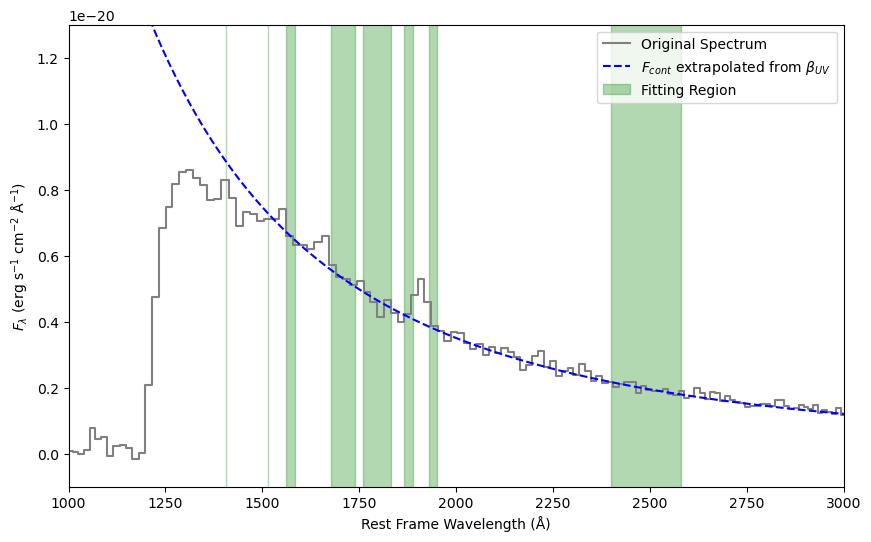

In [7]:
wavelength = rest_wave_angstroms.value
flux = tab['flux_erg_per_s_cm2_A'].value
flux_err = tab['flux_err_erg_per_s_cm2_A'].value

f_cont = extrapolate_continuum(wavelength, beta_median, log_FUV_1550_median)
plot_spectrum_with_continuum(wavelength, flux, f_cont, regions)


In [9]:
DLyA = calculate_damping_parameter(wavelengths_angstroms.value, tab['flux_erg_per_s_cm2_A'].value, f_cont, z)
print(f"LyA Damping Parameter (D_LyA): {DLyA:.3f}")

12317.194 14091.705
[ 5800.          5836.85108575  5874.37877181  5912.60215572
  5951.54261248  5991.2193501   6031.65248683  6072.86642985
  6114.88328815  6157.72585211  6201.41792534  6245.98642172
  6291.45766441  6337.85840424  6385.21650689  6433.56097508
  6482.92196123  6533.33126973  6584.822006    6637.42768788
  6691.18309136  6746.12426771  6802.28854555  6859.71456092
  6918.44227959  6978.51298324  7039.96929833  7102.85608586
  7167.21912618  7233.1052915   7300.56280146  7369.64120146
  7440.39199792  7512.86878877  7587.12509139  7663.21592644
  7741.19919436  7821.13200726  7903.07387228  7987.08465118
  8073.22539419  8161.55753607  8252.14350276  8345.04545011
  8440.32600189  8538.04731418  8638.27101019  8741.05790039
  8846.46745841  8954.5571802   9065.38243932  9178.99600133
  9295.44739919  9414.78177978  9537.04006411  9662.25838531
  9790.46754736  9921.69165718 10055.94654102 10193.24339057
 10333.58162534 10476.95621183 10623.34809583 10772.73310423
 109